In [1]:
!pip install -e .
from studygroups_rl.policies.dec_policy import SimpleDECPolicy
from studygroups_rl.infrastructure import pytorch_util as ptu

Obtaining file:///C:/Users/anamt/OneDrive/Documents/Berkeley/research/group-matching-research
  Attempting uninstall: studygroups-rl
    Found existing installation: studygroups-rl 0.1.0
    Uninstalling studygroups-rl-0.1.0:
      Successfully uninstalled studygroups-rl-0.1.0
  Running setup.py develop for studygroups-rl


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import pickle

from sklearn.decomposition import PCA

In [3]:
path = 'ipynb/16a_fa20_data/'
matching_csv = pd.read_csv(path + "cleaned/matching_input.csv")

# input_df = pd.read_csv(path + "cleaned/input_encoded.csv")
# input_df = input_df.drop(columns=['id_importance', 'race_importance'])

with open('ipynb/input_df_large.pkl', 'rb') as file:
    input_df = pickle.load(file)
group_scores = pd.read_csv(path + "cleaned/group_scores.csv")
print(input_df.columns)
print("\n Overall group scores:", group_scores.columns)

Index(['email', 'first', 'last', 'sid', 'courses_completed_61A',
       'courses_completed_61A, Linear Algebra course at a community college',
       'courses_completed_61A, Math 54 (Note Math 54 is not required at all for the L&S or EECS major and is not required for 16A)',
       'courses_completed_Linear Algebra course at a community college',
       'courses_completed_Math 1A', 'courses_completed_Math 1A, 61A',
       ...
       'experience_I have had some exposure to linear algebra',
       'experience_I have had some exposure to programming',
       'experience_I have had some exposure to programming, I have had lots of exposure to linear algebra',
       'experience_I have had some exposure to programming, I have had some exposure to linear algebra',
       'experience_I have had some exposure to programming, I have not had much exposure to linear algebra',
       'experience_I have had some exposure to programming, I have not had much exposure to linear algebra, I have had some

In [4]:
group_stud_rew = pd.read_csv(path + "cleaned/stud_group_scores.csv").set_index('Unnamed: 0')
group_stud_rew.head()

group_num                          email         sid       first  \
Unnamed: 0                                                                     
0                   0  shiladitya_dutta@berkeley.edu  3035558447  Shiladitya   
1                   1        jerrygao12@berkeley.edu  3035624812       Jerry   
2                   1        suryarajan@berkeley.edu  3035853261       Surya   
3                   4          jane-lee@berkeley.edu  3035605819        Jane   
4                   4        patrickcui@berkeley.edu  3035781033     Patrick   

             last                                  incoming_partners  \
Unnamed: 0                                                             
0           Dutta  ['jermxt@berkeley.edu', 'shiladitya_dutta@berk...   
1             Gao  ['suryarajan@berkeley.edu', 'skywire2000@berke...   
2           Rajan  ['suryarajan@berkeley.edu', 'jerrygao12@berkel...   
3             Lee  ['patrickcui@berkeley.edu', 'ivan_mao@berkeley...   
4             Cui  ['patrickcui@berkeley.edu', 'ivan_mao@berkeley...   

                                            outgoing_partners  \
Unnamed: 0                                                      
0                                     ['jermxt@berkeley.edu']   
1           ['skywire2000@berkeley.edu', 'suryarajan@berke...   
2           ['skywire2000@berkeley.edu', 'jerrygao12@berke...   
3           ['ivan_mao@berkeley.edu', 'neelchoudhary@berke...   
4           ['jane-lee@berkeley.edu', 'ivan_mao@berkeley.e...   

           pregroup_partner  group_score  
Unnamed: 0                                
0                       NaN         7.50  
1                       NaN        10.75  
2                       NaN        12.50  
3                       NaN        14.75  
4                       NaN        13.25

In [5]:
X = input_df.drop(columns=['email', 'first', 'last', 'sid']).to_numpy()
X.shape

(525, 134)

In [6]:

split_idxs = np.random.permutation(X.shape[0])
X_train = X[split_idxs[:int(.10*X.shape[0])]]
X_eval = X[split_idxs[int(.10*X.shape[0]):]]

### DEC Testing

In [7]:
# ## Hyperparameters
# ae_iters = 10000
# dec_iters = 6000
# batch_size = 20

# agent_params = {
#     'input_dim' : X.shape[1],
#     'hidden_dim' : 32,
#     'n_hidden_layers' : 2,
#     'latent_dim' : 4,
#     'layer_activation' : 'relu',
#     'output_activation' : 'relu',
#     'use_dropout' : True,
#     'k':X.shape[0]//4,
#     'lr':.0001,
#     'ae_lr':.0015,
#     'dropout_rate':0.3
# }


### Autoencoder training

In [8]:
# def run_dec_ae(t_iters, agent_params, return_model=True):
#     print("Training on hyperparams: ", agent_params['ae_lr'], t_iters, agent_params['dropout_rate'])
#     dec_actor = SimpleDECPolicy(agent_params)
#     ## Run AE training
#     ae_losses = []
#     valid_losses = []
#     for i in range(t_iters):
#         X_batch = X_train[np.random.choice(X_train.shape[0], batch_size, replace=False)]
#         loss = dec_actor.update_ae(X_batch)
#         if (i%(t_iters//5) == 0):
#             ae_losses.append(loss["Autoencoder loss"])
#             print(i, "iterations- Loss: ", loss["Autoencoder loss"])
#             valid_loss = dec_actor.ae_loss(dec_actor.ae.forward_eval(ptu.from_numpy(X_eval)), 
#                                             ptu.from_numpy(X_eval)).item()
#             ae_losses.append(loss["Autoencoder loss"])
#             valid_losses.append(valid_loss)

In [9]:
def run_dec_ae(t_iters, agent_params, return_model=True):
    print("Training on hyperparams: ", agent_params['ae_lr'], t_iters, agent_params['dropout_rate'])
    dec_actor = SimpleDECPolicy(agent_params)
    ## Run AE training
    ae_losses = []
    valid_losses = []
    best_valid_loss = 1
    keep_dec = None
    for i in range(t_iters):
        X_batch = X_train[np.random.choice(X_train.shape[0], batch_size, replace=False)]
        loss = dec_actor.update_ae(X_batch)
        valid_loss = dec_actor.ae_loss(dec_actor.ae.forward_eval(ptu.from_numpy(X_eval)), 
                                        ptu.from_numpy(X_eval)).item()
        if (i%(t_iters//5) == 0):
            ae_losses.append(loss["Autoencoder loss"])
            print(i, "iterations- Training Loss: ", loss["Autoencoder loss"], ", Validation loss: ", valid_loss)
            valid_losses.append(valid_loss)
            
    ae_losses.append(loss["Autoencoder loss"])
    valid_loss = dec_actor.ae_loss(dec_actor.ae.forward_eval(ptu.from_numpy(X_eval)), 
                                    ptu.from_numpy(X_eval)).item()
    valid_losses.append(valid_loss)
    ## Validation loss
    print("Final validation loss:", valid_loss)
    print()
    
    
    if return_model:
        return ae_losses, valid_losses, dec_actor
    else:
        del dec_actor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        return ae_losses, valid_losses, None
        

In [10]:
# lrs = [1e-6, 3e-6, 5e-6, 1e-5, 2e-5, 5e-5]
# dropout_rates = [0, 0.05, 0.1, 0.15]
# train_losses = np.zeros((len(lrs), len(dropout_rates), 5))
# valid_losses = np.zeros((len(lrs), len(dropout_rates), 5))
# ae_iters = 60000
# best_valid_loss = 500
# best_model = None
# idxs = (None, None)

# for i1 in range(len(lrs)):
#     for i2 in range(len(dropout_rates)):
#         agent_params = {
#             'input_dim' : X.shape[1],
#             'hidden_dim' : 32,
#             'n_hidden_layers' : 2,
#             'latent_dim' : 8,
#             'layer_activation' : 'relu',
#             'output_activation' : 'identity',
#             'use_dropout' : True,
#             'k':X.shape[0]//4,
#             'lr':.0001,
#             'ae_lr':lrs[i1],
#             'dropout_rate':dropout_rates[i2]
#         }
#         train_losses[i1, i2], valid_losses[i1, i2], model = run_dec_ae(ae_iters, agent_params)
#         if valid_losses[i1, i2] < best_valid_loss:
#             best_valid_loss = valid_losses[i1, i2]
#             best_model = model
#             idxs = (i1, i2)

In [11]:
# lrs = [3e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4]
# dropout_rates = [0, 0.05, 0.1]
# ae_iters = 140000
# train_losses = np.zeros((len(lrs), len(dropout_rates), 6))
# valid_losses = np.zeros((len(lrs), len(dropout_rates), 6))
# best_valid_loss = 0.042
# best_model = None
# idxs = (None, None)

# for i1 in range(len(lrs)):
#     for i2 in range(len(dropout_rates)):
#         agent_params = {
#             'input_dim' : X.shape[1],
#             'hidden_dim' : 24,
#             'n_hidden_layers' : 2,
#             'latent_dim' : 8,
#             'layer_activation' : 'relu',
#             'output_activation' : 'identity',
#             'use_dropout' : True,
#             'k':X.shape[0]//4,
#             'lr':.0001,
#             'ae_lr':lrs[i1],
#             'dropout_rate':dropout_rates[i2]
#         }
#         train_losses[i1, i2], valid_losses[i1, i2], model = run_dec_ae(ae_iters, agent_params)
#         if np.min(valid_losses[i1, i2]) < best_valid_loss:
#             best_valid_loss = np.min(valid_losses[i1, i2])
#             best_model = model
#             idxs = (i1, i2)

In [12]:
# print("Best validation loss", best_valid_loss)

In [13]:
# plt.plot(np.arange(len(train_losses[idxs[0], idxs[1]])), train_losses[idxs[0], idxs[1]])
# plt.title("Best training loss over iterations")

In [14]:
# print("Best hyperparameters:", lrs[idxs[0]], dropout_rates[idxs[1]])

In [15]:
# agent_params = {
#             'input_dim' : X.shape[1],
#             'hidden_dim' : 32,
#             'n_hidden_layers' : 2,
#             'latent_dim' : 8,
#             'layer_activation' : 'relu',
#             'output_activation' : 'identity',
#             'use_dropout' : True,
#             'k':X.shape[0]//4,
#             'lr':.0001,
#             'ae_lr':5e-5,
#             'dropout_rate':0.1
#         }
# train_loss_best, valid_loss_best, dec_actor = run_dec_ae(30000, agent_params)
# print("Best validation loss", valid_loss_best)

In [18]:
# #More complex architecture
agent_params = {
            'input_dim' : X.shape[1],
            'hidden_dim_ae' : 24,
            'n_hidden_layers_ae' : 2,
            'latent_dim' : 8,
            'layer_activation_ae' : 'relu',
            'output_activation' : 'identity',
            'use_dropout' : True,
            'k':X.shape[0]//4,
            'group_size':4,
            'lr':.00005,
            'ae_lr':1e-5,
            'dropout_rate':0
        }
batch_size = 20
train_loss_best, valid_loss_best, best_model = run_dec_ae(60000, agent_params)
print("Validation loss", valid_loss_best)

Training on hyperparams:  1e-05 60000 0
0 iterations- Training Loss:  0.0709989070892334 , Validation loss:  0.07826235145330429
12000 iterations- Training Loss:  0.027784163132309914 , Validation loss:  0.03376007080078125
24000 iterations- Training Loss:  0.016656655818223953 , Validation loss:  0.028182215988636017
36000 iterations- Training Loss:  0.021592935547232628 , Validation loss:  0.02657479979097843
48000 iterations- Training Loss:  0.015444569289684296 , Validation loss:  0.0256715789437294
Final validation loss: 0.025103654712438583

Validation loss [0.07826235145330429, 0.03376007080078125, 0.028182215988636017, 0.02657479979097843, 0.0256715789437294, 0.025103654712438583]


In [19]:
!touch best_ae_trained.pkl
with open("best_ae_trained.pkl", "wb") as file:
    pickle.dump(best_model, file)

## After training best AE model

In [20]:
with open("best_ae_trained.pkl", "rb") as file:
    best_model = pickle.load(file)
dec_actor=best_model

Text(0.5, 1.0, 'Prediction of survey responses')

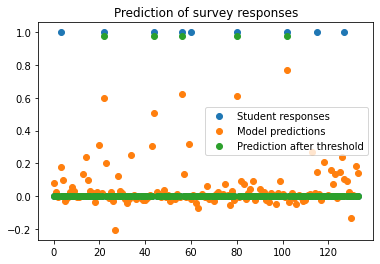

In [32]:
print(plt.scatter(np.arange(X.shape[1]),X_eval[5]))
pred = ptu.to_numpy(dec_actor.ae.forward_eval(ptu.from_numpy(X_eval[5])).detach())
print(plt.scatter(np.arange(X.shape[1]),pred))

print(plt.scatter(np.arange(X.shape[1]),0.98*(pred>.44)))
plt.legend(["Student responses", "Model predictions", "Prediction after threshold"])
plt.title("Prediction of survey responses")

Text(0.5, 1.0, 'Prediction of survey responses')

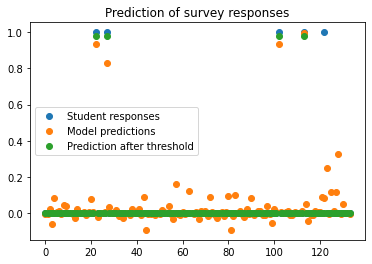

In [31]:
print(plt.scatter(np.arange(X.shape[1]),X_eval[3]))
pred = ptu.to_numpy(dec_actor.ae.forward_eval(ptu.from_numpy(X_eval[3])).detach())
print(plt.scatter(np.arange(X.shape[1]),pred))

print(plt.scatter(np.arange(X.shape[1]),0.98*(pred>.44)))
plt.legend(["Student responses", "Model predictions", "Prediction after threshold"])
plt.title("Prediction of survey responses")

### DEC clustering training 

In [21]:
dec_actor.initialize_centers(X)
print(dec_actor.mu.detach().numpy())

[[ 2.96349835e+00 -4.85947418e+00 -6.61284208e-01  3.74699187e+00
   1.92179048e+00 -4.77484465e+00 -2.42897344e+00 -7.20442414e-01]
 [ 2.13808227e+00 -2.34362841e+00 -1.24477744e+00  3.40747142e+00
   2.58101368e+00 -2.04847050e+00 -1.81741345e+00 -5.63529313e-01]
 [ 2.82467461e+00 -3.37230396e+00 -2.52424765e+00  2.12740111e+00
   1.44526935e+00 -4.52442598e+00 -2.02559590e+00 -9.57416654e-01]
 [ 3.94853878e+00 -3.07596707e+00 -4.10924196e-01  1.93416691e+00
   3.65626693e-01 -1.89182234e+00 -1.33624721e+00 -2.04566121e-02]
 [ 1.09862721e+00 -2.26658726e+00  2.50962377e-01  1.60870016e+00
   8.76770496e-01 -3.57814312e+00 -1.77644157e+00  4.36901152e-01]
 [ 1.37543869e+00 -8.09667110e-01 -2.71805644e+00  1.02790022e+00
   9.30196166e-01 -3.03325963e+00 -2.64081144e+00  7.39741087e-01]
 [ 4.06359863e+00 -3.26874089e+00 -2.45083141e+00  4.66335583e+00
   8.33674371e-01 -5.85606098e+00 -4.13803482e+00 -5.45924842e-01]
 [ 1.64261580e-01 -1.00281811e+00 -2.91766596e+00  1.77476799e+00
   

In [22]:
import torch

In [26]:
def get_action_nearest_mu(dec_actor, observation) -> np.ndarray:
        n = observation.size()[0]
        p, q, z = dec_actor.forward(observation)
        
        print(p.size())
        
#         print(mu_freq.size())
        mu_freq = torch.sum(p, dim=0)
        mus_sorted = torch.argsort(mu_freq)
#         print(mus_sorted.)

        groups = torch.zeros((dec_actor.k,dec_actor.group_size,dec_actor.latent_dim))
        groups_idxs = torch.zeros((dec_actor.k,dec_actor.group_size))
        # new_groups = torch.zeros((self.k, self.group_size,self.latent_dim))
        stud_assignments = torch.zeros((n,1))

        for mu in mus_sorted:
            studs_mu = torch.argsort(p[:,mu], descending=True)[:dec_actor.group_size]
#             print(studs_mu)
            groups[mu] = z[studs_mu]
            groups_idxs[mu] = studs_mu
            for stud in studs_mu:
                stud_assignments[stud] = mu
                p[stud] = 0#10*torch.ones((1,self.k))
#         print(groups)
        new_mus = groups.mean(dim=1)
#         print(new_mus)
        # print(new_mus.size())
        return stud_assignments, new_mus, groups_idxs


In [64]:
def visualize_dec_results(dec_actor, X, verbose=False, use_pca=True):
    stud_assignments, new_mus, groups = \
         get_action_nearest_mu(dec_actor, ptu.from_numpy(X))
    assignments = ptu.to_numpy(stud_assignments).astype(int).squeeze()
    new_mus = ptu.to_numpy(new_mus)
    if verbose:
        print(ptu.to_numpy(groups))
        print(np.unique(new_mus, axis=0, return_counts=True))

    p, q, z = dec_actor.forward(ptu.from_numpy(X))
    z = ptu.to_numpy(z)
    latent_students = z
    centroids = new_mus#dec_actor.mu.detach().numpy()
    
    if use_pca:
        # Perform PCA to project 
        pca = PCA(n_components=8)
        pca.fit(z)
        print(pca.explained_variance_ratio_)
        latent_students = pca.transform(z)
        latent_students

        centroids = pca.transform(new_mus)
        
        plt.scatter(latent_students[:,0], latent_students[:,1], c = assignments,cmap=plt.cm.Paired)
        plt.title("Student groups projected across 2 PCA dimensions")
        plt.show()
        
    else:
        for i in range(dec_actor.latent_dim):
            for j in range(i+1,dec_actor.latent_dim):
                plt.scatter(latent_students[:,i], latent_students[:,j], c = assignments,cmap=plt.cm.Paired)
                plt.title("Student groups projected across latent dimensions " + str(i) + " and " + str(j))
                plt.show()

    for i in range(centroids.shape[0]):
        plt.xlim(np.min(centroids[:, 0])-.5, .5+np.max(centroids[:, 0]))
        plt.ylim(np.min(centroids[:, 1])-.5, .5+np.max(centroids[:, 1]))
        plt.scatter(centroids[i, 0],centroids[i, 1],marker="x",s=169,
            linewidths=3,color="black",zorder=10)
        plt.scatter(latent_students[assignments==i][:,0], latent_students[assignments==i][:,1]) #, c = assignments[i],cmap=plt.cm.Paired)


        plt.title(
            "Sampled cluster " + str(i) +  "\n"+
            "across latent dimensions 0 and 1 \n"+
            "Centroids are marked with cross"
        )
        plt.show()

torch.Size([472, 118])
[[359. 246. 193. 390.]
 [276. 306. 332. 425.]
 [249. 404.  89. 441.]
 [286. 192. 318.  98.]
 [174.  52. 255.  72.]
 [ 35. 377.  68. 274.]
 [102. 177. 423. 335.]
 [245.  27.  17. 256.]
 [125. 127. 430. 442.]
 [225.  86. 384. 253.]
 [468. 107. 331. 389.]
 [215.   5. 163. 130.]
 [279. 392. 464. 173.]
 [  0. 120. 411. 267.]
 [176. 324.   3. 393.]
 [436. 233. 268. 185.]
 [269.  54. 229.  64.]
 [144. 243. 171. 142.]
 [395. 450. 194. 222.]
 [203. 344.  14. 408.]
 [330. 310.  24. 467.]
 [327.  59. 129. 132.]
 [ 83. 138. 254. 161.]
 [321. 208. 383. 463.]
 [154. 399. 363. 294.]
 [304.  49. 117.  20.]
 [ 33. 200.  43. 349.]
 [109. 133. 272. 334.]
 [280. 167. 226. 219.]
 [459. 121.   9. 182.]
 [301. 416. 341. 417.]
 [ 30. 410. 471. 440.]
 [ 94. 134. 314.  57.]
 [ 11. 351. 216. 244.]
 [ 19. 205.  22.  51.]
 [155. 281. 190. 248.]
 [141. 213. 345. 241.]
 [263. 405. 227.  62.]
 [261. 439. 110. 435.]
 [206. 195.  53. 305.]
 [469. 342. 470. 152.]
 [302. 140. 273. 374.]
 [364.  61.

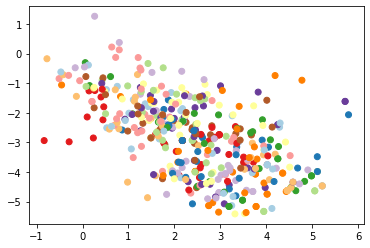

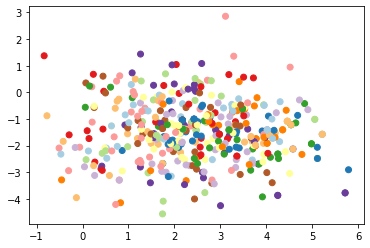

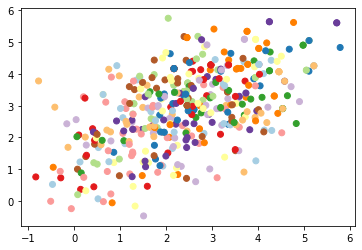

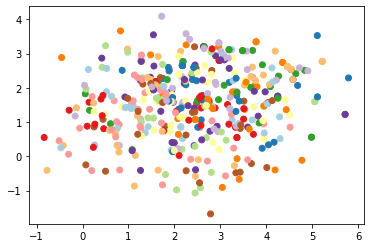

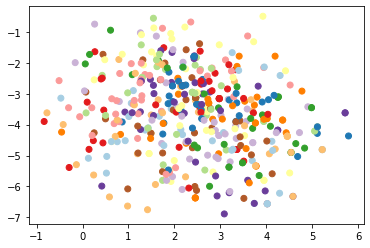

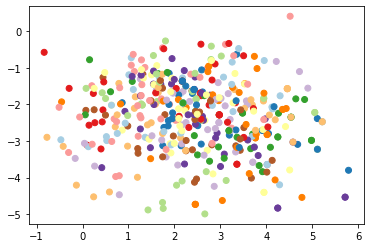

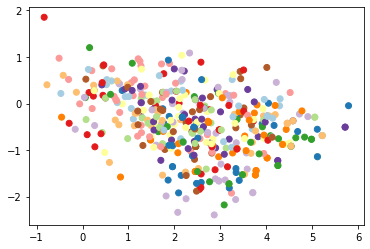

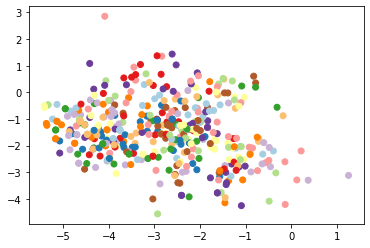

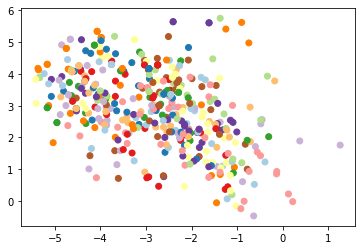

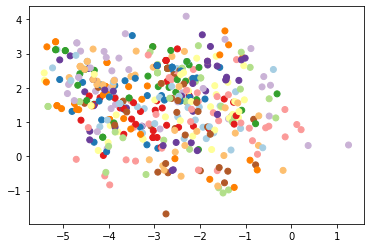

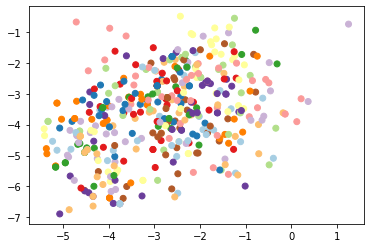

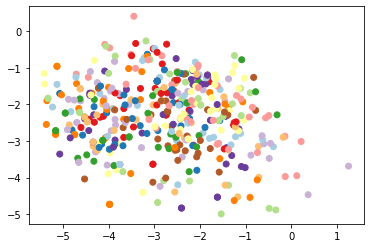

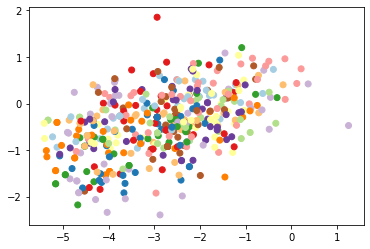

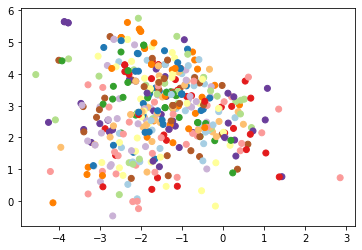

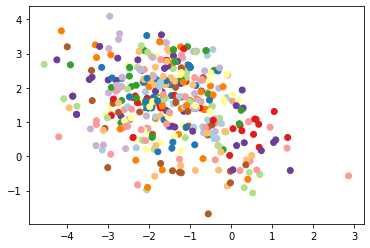

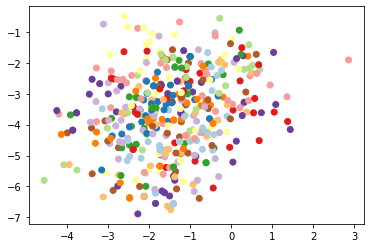

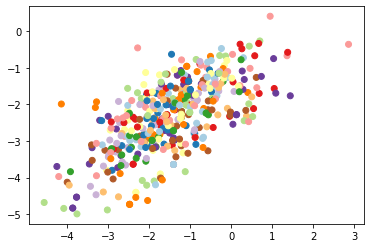

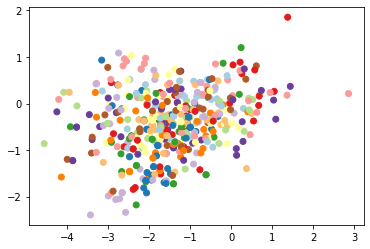

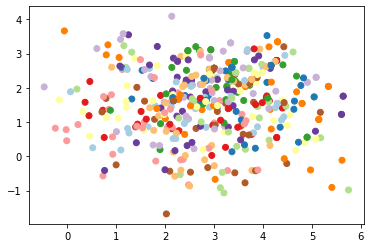

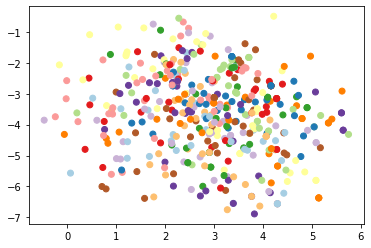

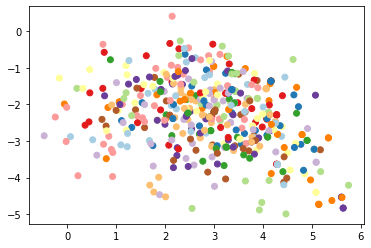

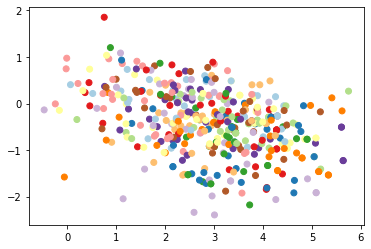

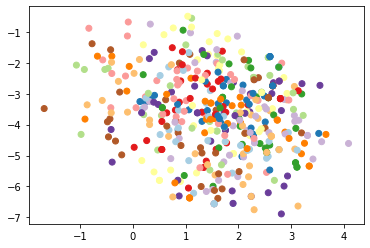

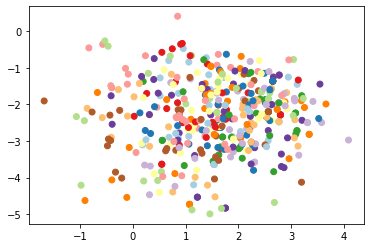

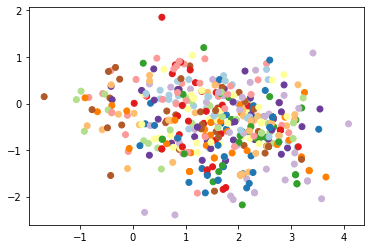

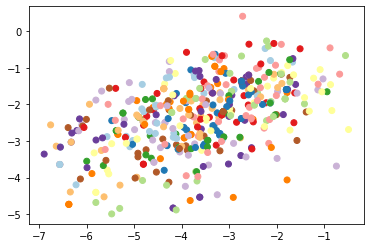

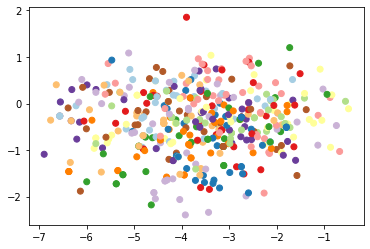

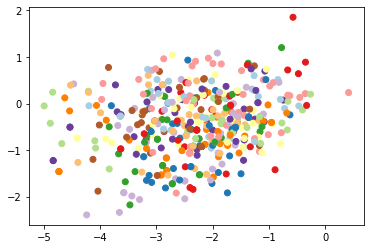

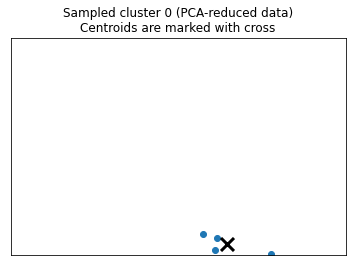

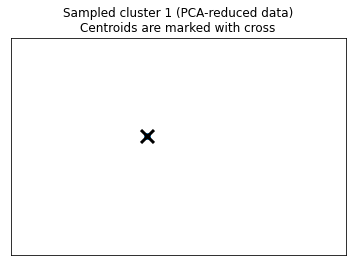

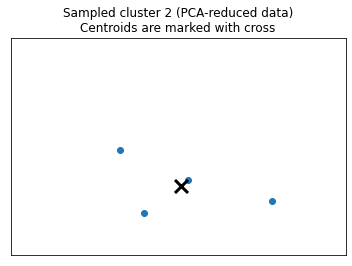

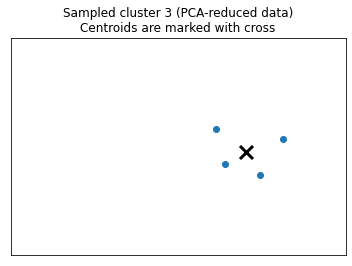

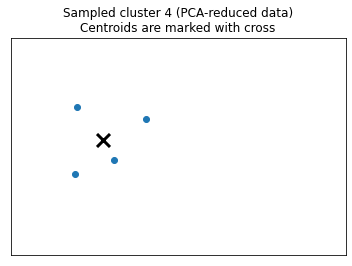

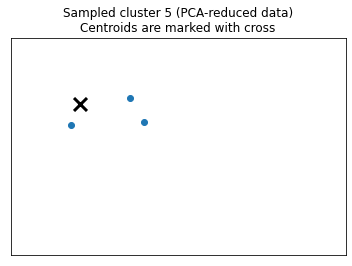

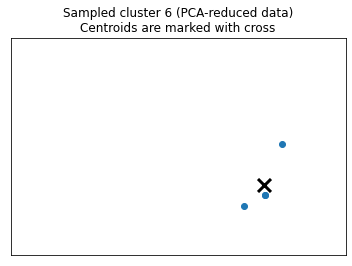

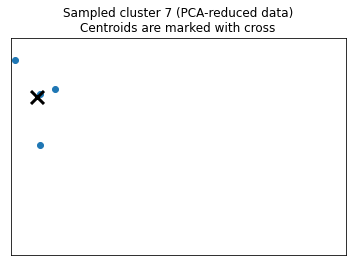

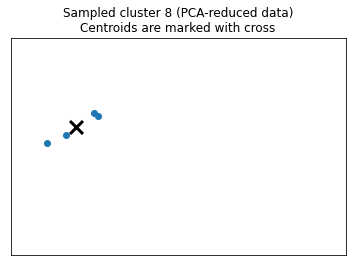

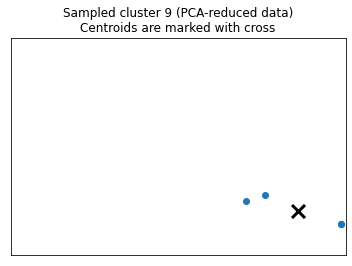

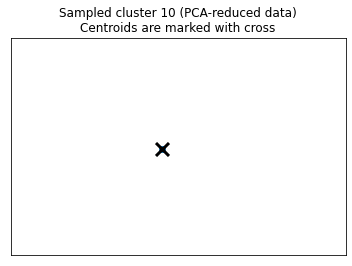

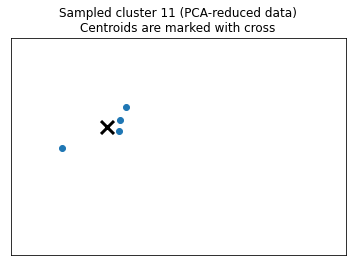

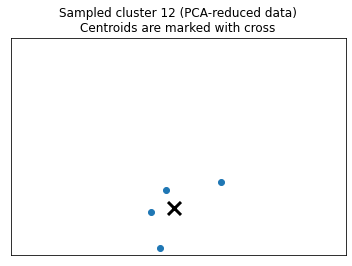

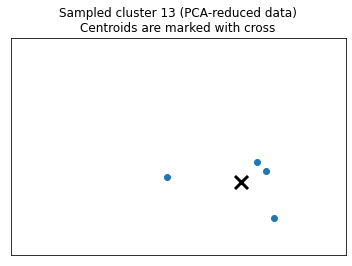

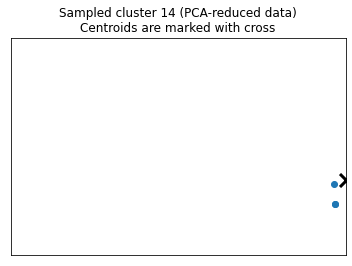

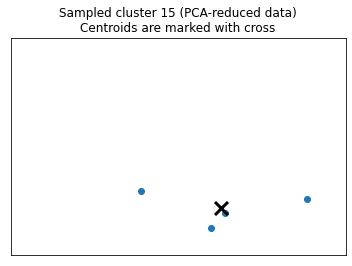

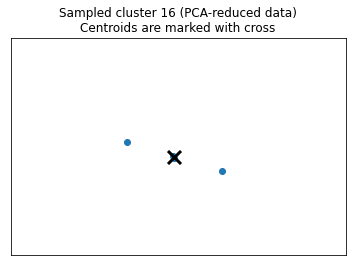

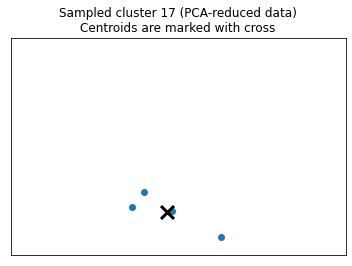

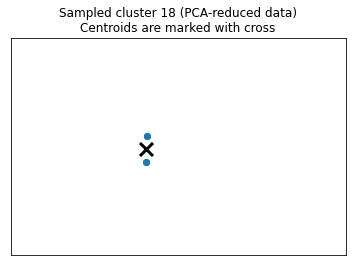

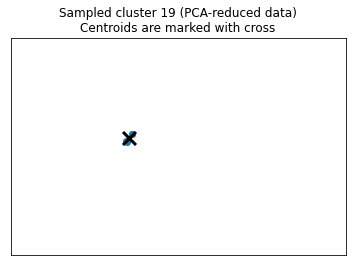

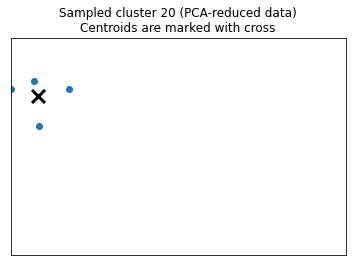

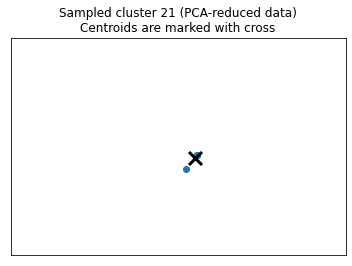

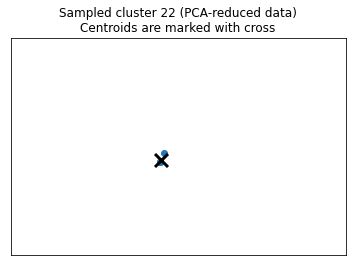

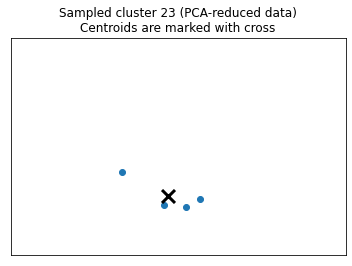

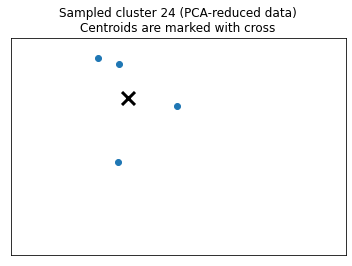

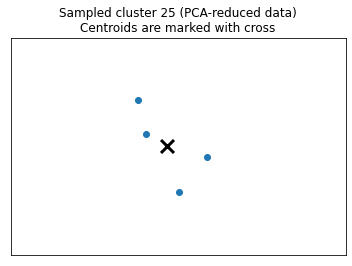

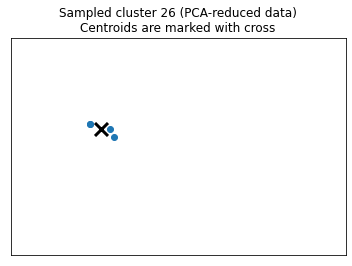

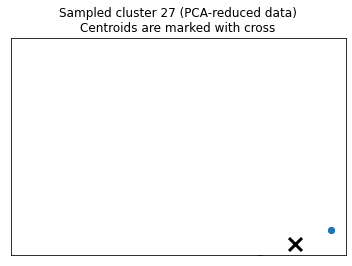

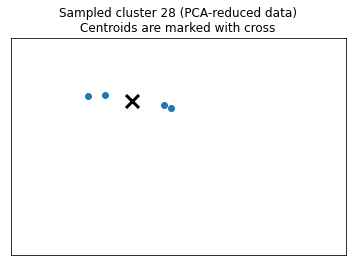

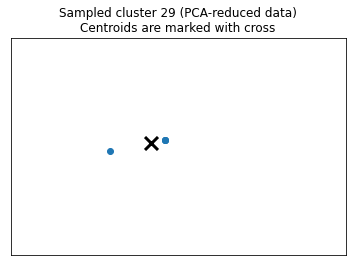

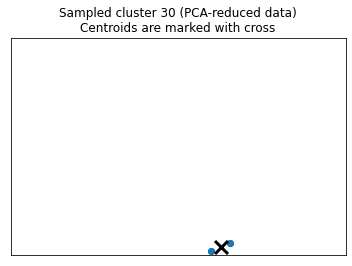

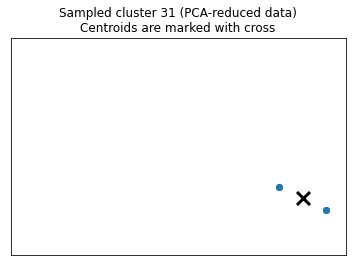

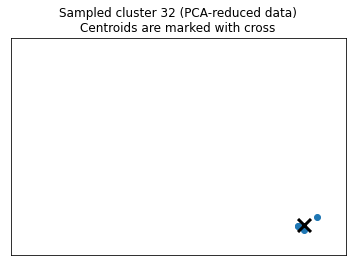

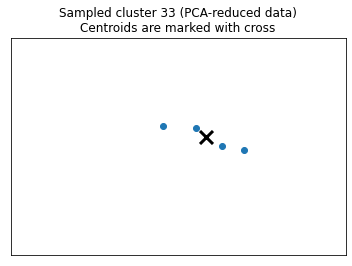

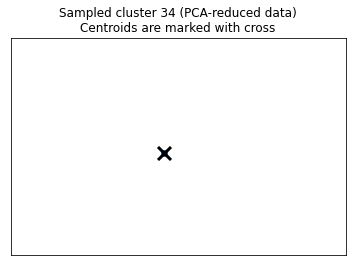

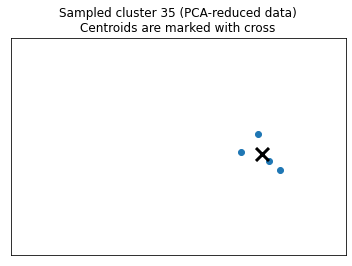

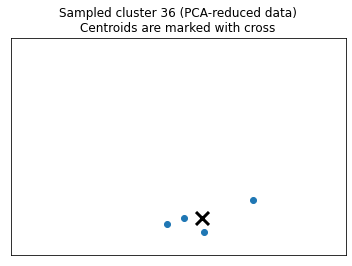

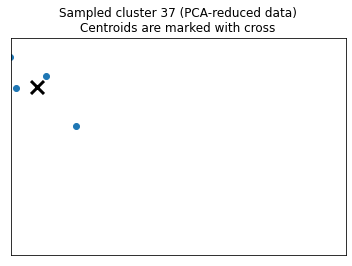

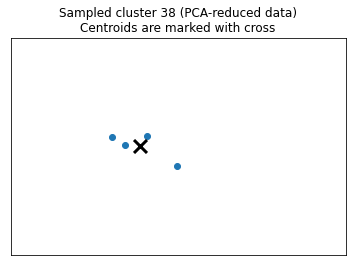

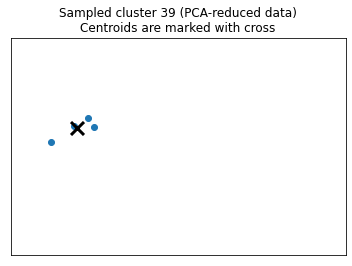

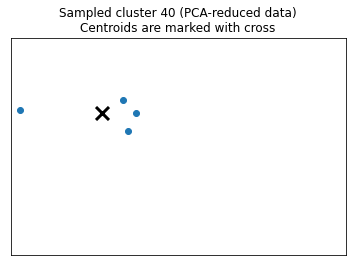

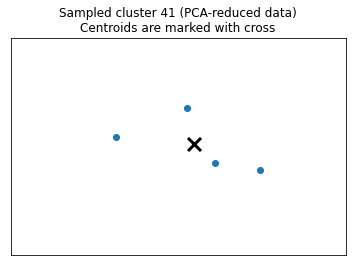

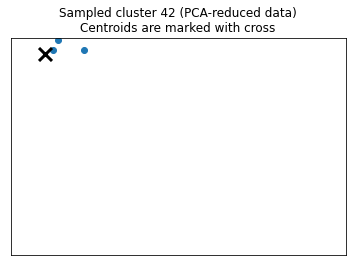

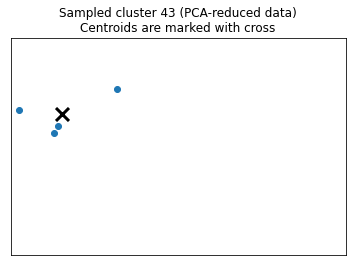

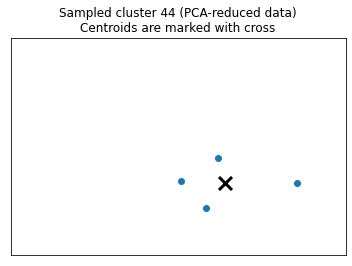

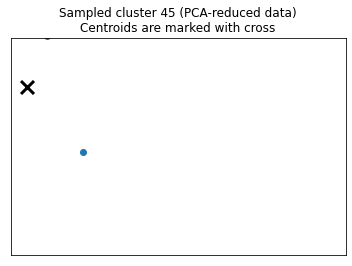

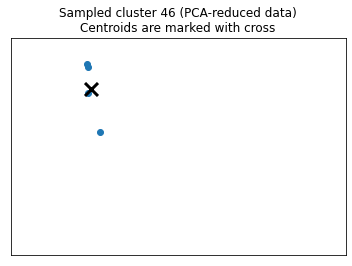

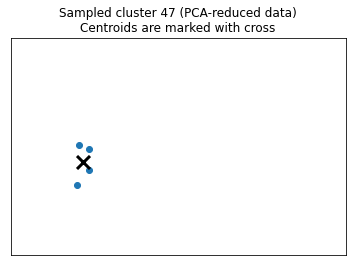

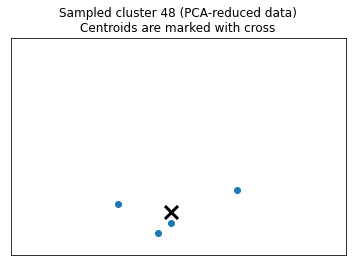

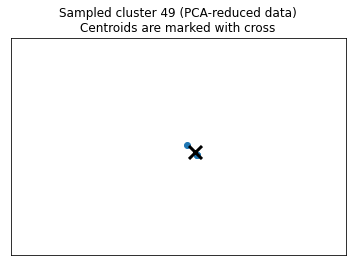

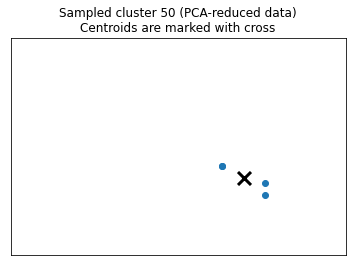

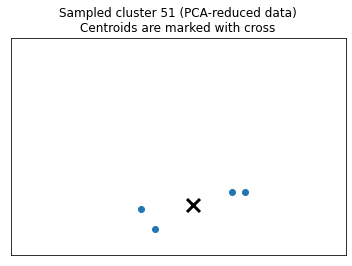

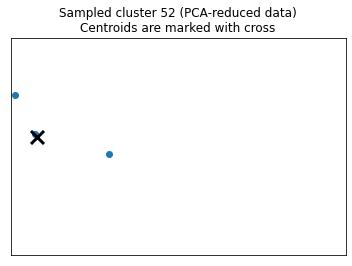

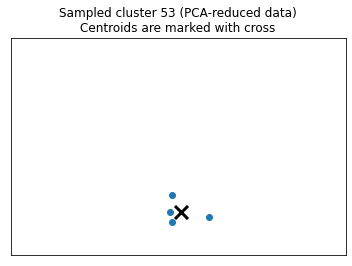

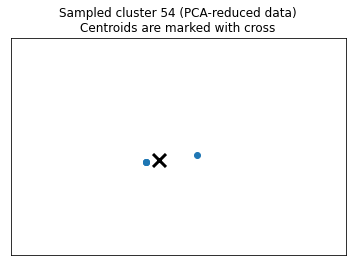

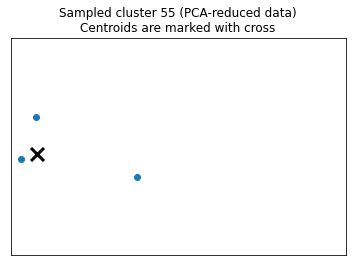

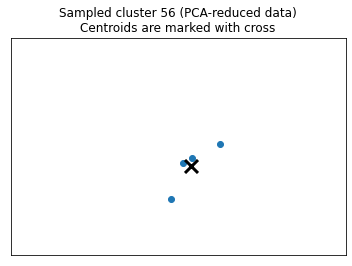

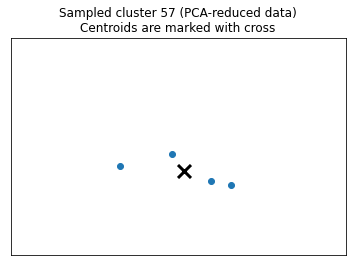

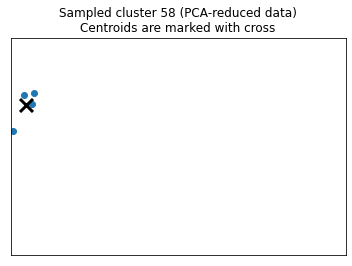

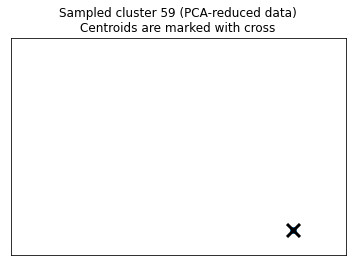

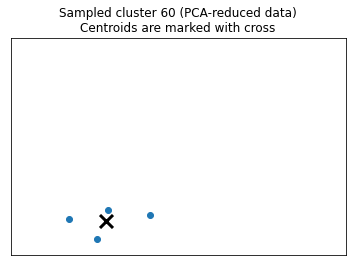

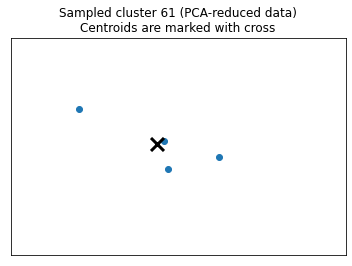

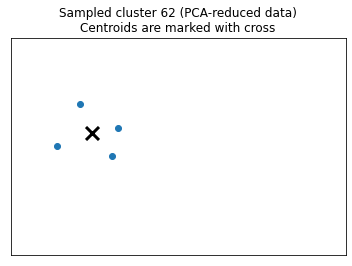

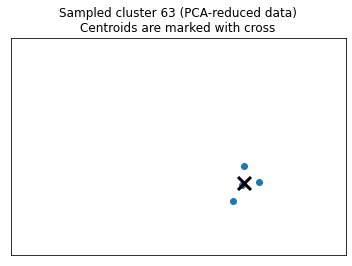

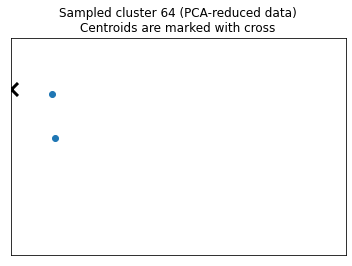

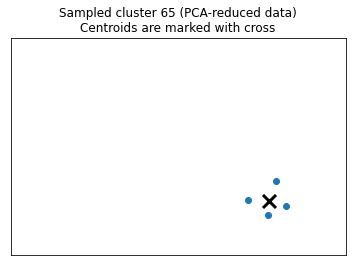

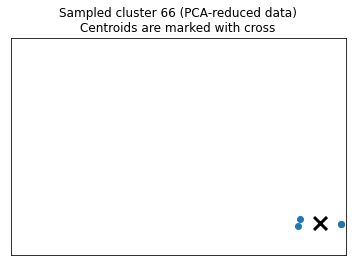

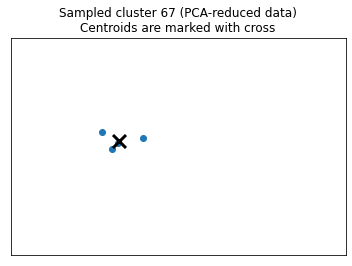

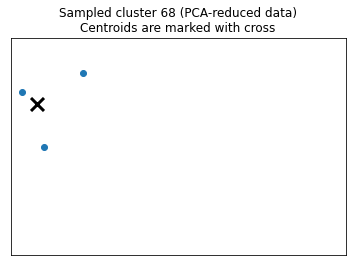

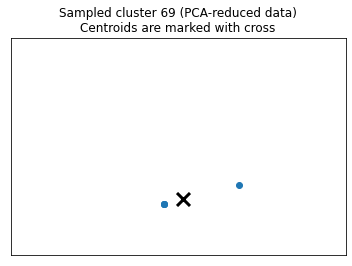

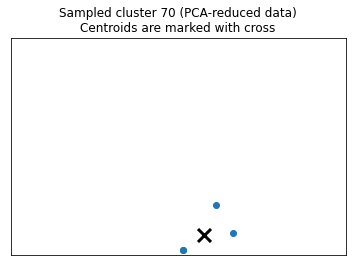

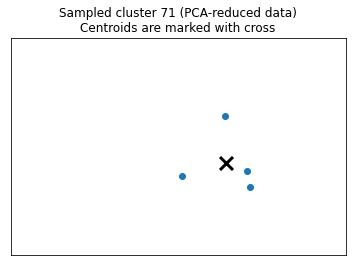

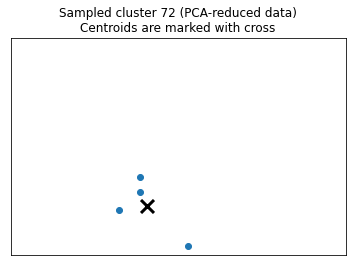

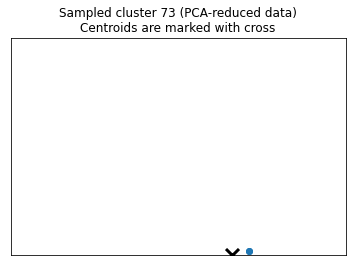

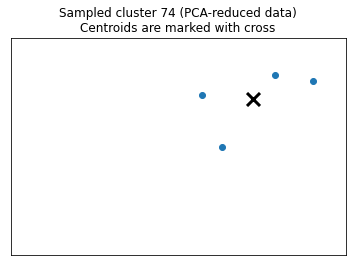

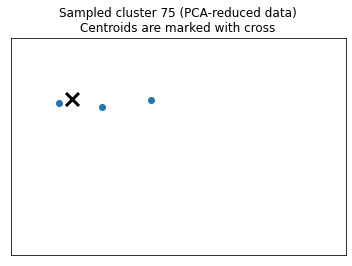

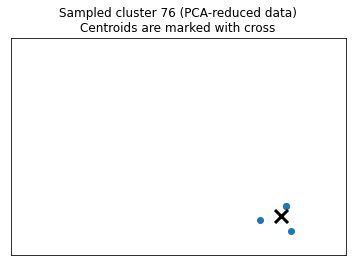

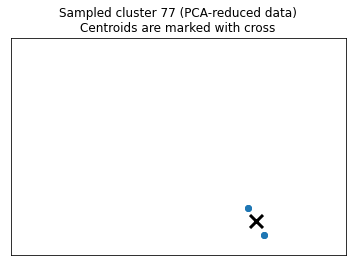

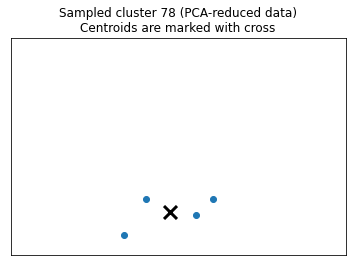

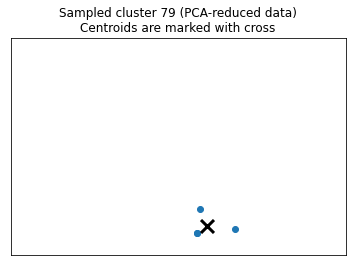

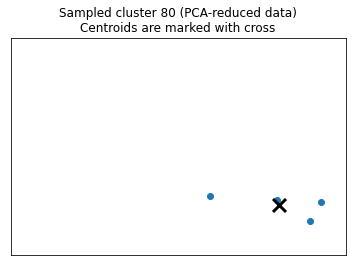

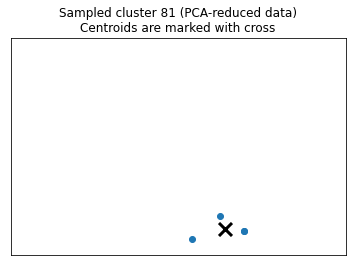

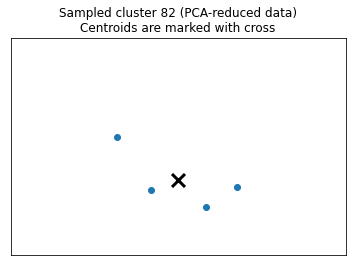

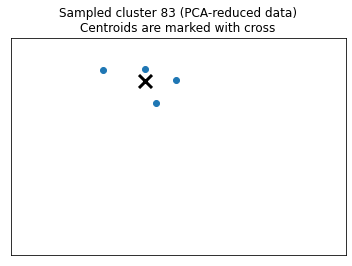

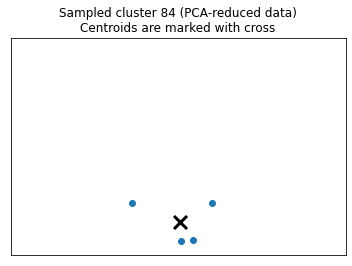

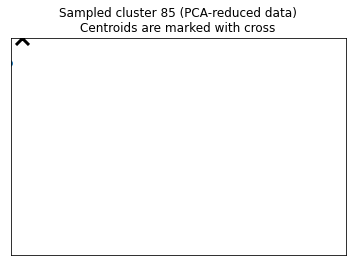

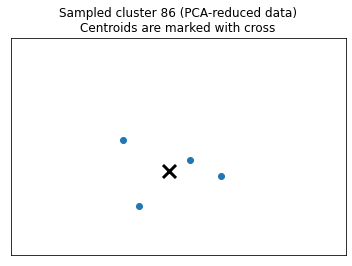

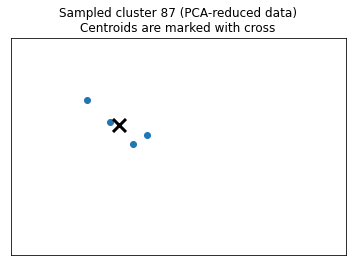

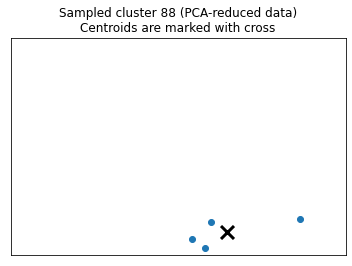

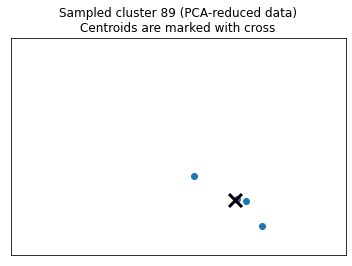

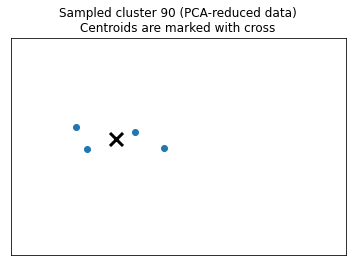

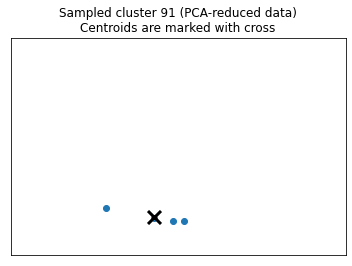

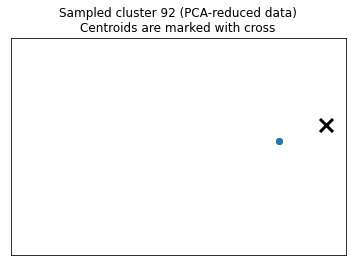

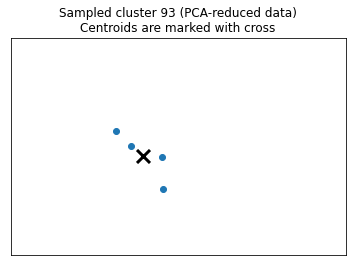

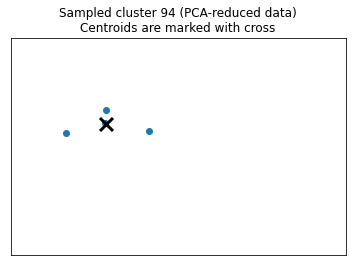

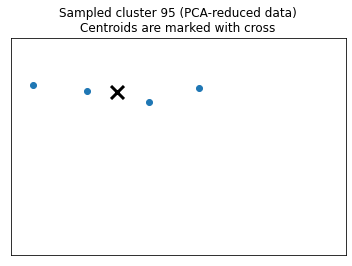

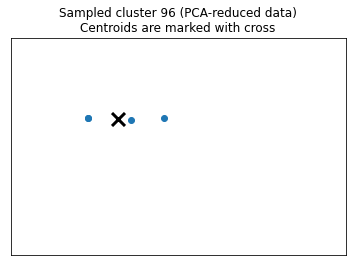

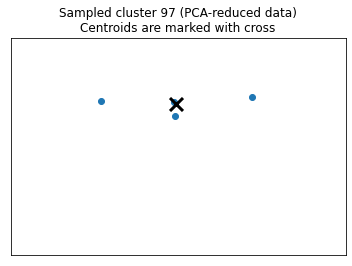

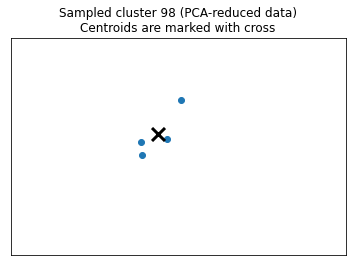

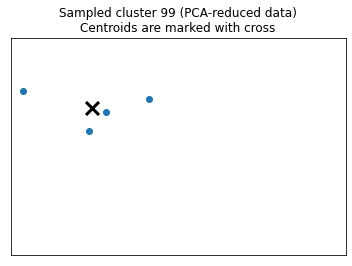

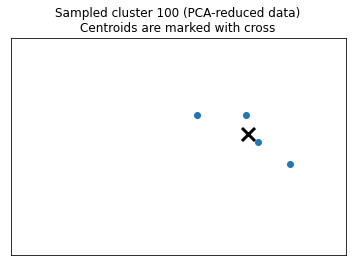

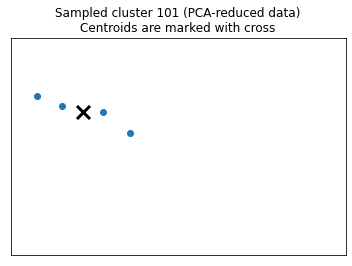

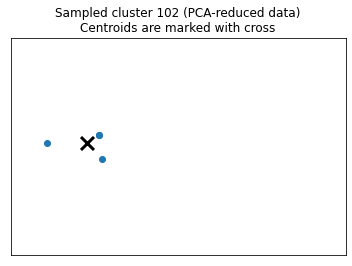

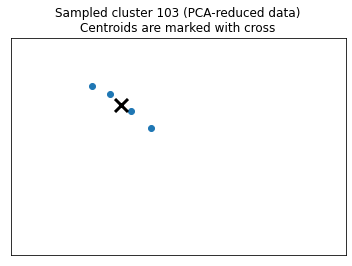

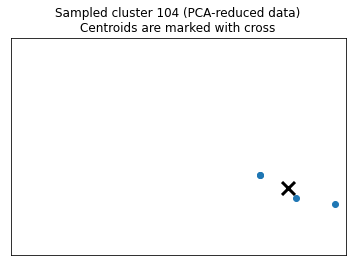

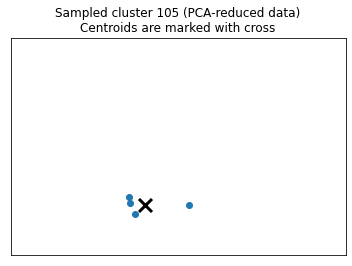

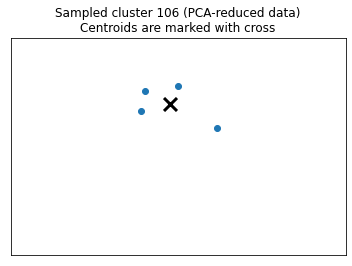

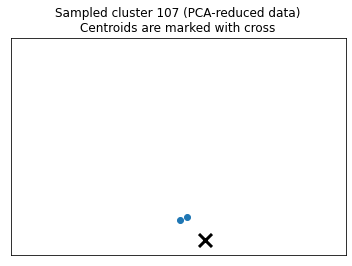

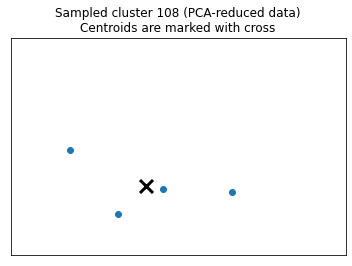

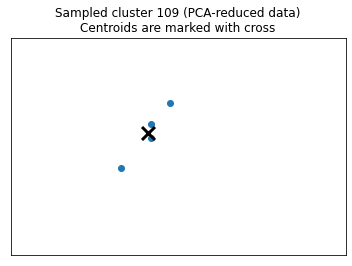

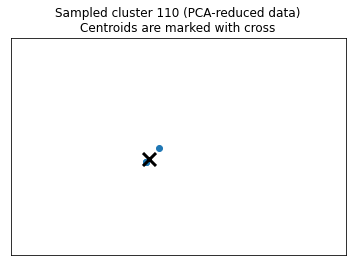

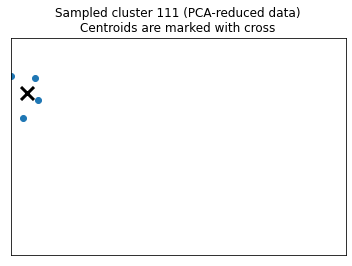

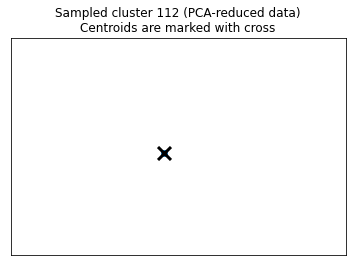

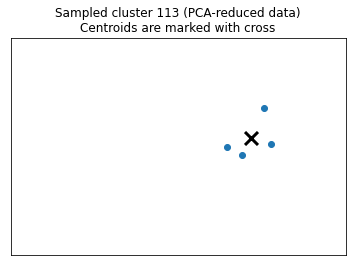

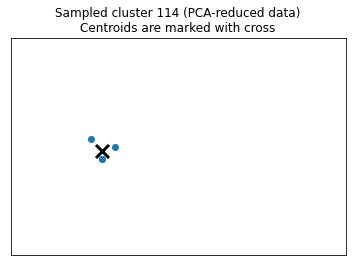

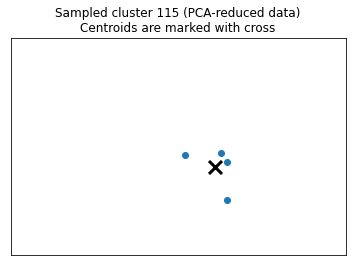

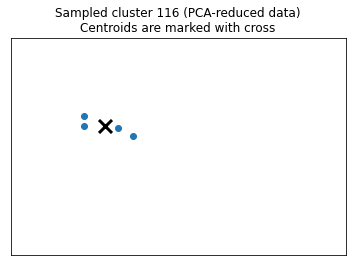

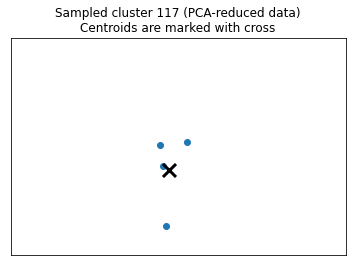

In [28]:
visualize_dec_results(dec_actor, X)

In [29]:
split_idxs = np.random.permutation(X.shape[0])
X_train = X[split_idxs[:int(.10*X.shape[0])]]
X_eval = X[split_idxs[int(.10*X.shape[0]):]]

In [40]:
## Run DEC training
dec_iters = 10000
num_epochs=4
batch_size = 20
dec_losses = []
for i in range(num_epochs):
    for i in range(dec_iters):
        X_batch = X_train[np.random.choice(X_train.shape[0], batch_size, replace=False)]
        loss = dec_actor.update_dec(X_batch)
        dec_losses.append(loss["Policy KL Divergence"])
        if (i%(dec_iters//10) == 0):
            print(i, "iterations- DEC Loss: ", loss["Policy KL Divergence"])
        ## Eval
    p_eval, q_eval, z = dec_actor.forward(ptu.from_numpy(X_eval))
    print("Eval loss: ",dec_actor.kl_loss(p_eval, q_eval).item())

0 iterations- DEC Loss:  0.0006166323437355459
1000 iterations- DEC Loss:  0.000513846636749804
2000 iterations- DEC Loss:  0.00023062535910867155
3000 iterations- DEC Loss:  7.087588892318308e-05
4000 iterations- DEC Loss:  2.9056973289698362e-05
5000 iterations- DEC Loss:  2.6847654226003215e-05
6000 iterations- DEC Loss:  1.9399441953282803e-05
7000 iterations- DEC Loss:  9.538403901387937e-06
8000 iterations- DEC Loss:  4.049576091347262e-06
9000 iterations- DEC Loss:  3.563343852874823e-06
Eval loss:  0.00023672409588471055
0 iterations- DEC Loss:  1.1192696547368541e-07
1000 iterations- DEC Loss:  -5.487072485266253e-07
2000 iterations- DEC Loss:  1.9223389244871214e-06
3000 iterations- DEC Loss:  -2.466831574565731e-07
4000 iterations- DEC Loss:  -1.0278308764100075e-06
5000 iterations- DEC Loss:  -5.202646207180806e-07
6000 iterations- DEC Loss:  6.821511533416924e-07
7000 iterations- DEC Loss:  3.482891770545393e-07
8000 iterations- DEC Loss:  -5.075754643257824e-07
9000 itera

KeyboardInterrupt: 

In [41]:
dec_actor.mu

tensor([[-0.5655,  0.0772,  0.1285,  0.0101,  0.0897,  0.1161, -0.1455,  0.2386],
        [-0.5619,  0.0780,  0.1269,  0.0097,  0.0955,  0.1134, -0.1455,  0.2412],
        [-0.5618,  0.0785,  0.1257,  0.0051,  0.0950,  0.1159, -0.1452,  0.2436],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5657,  0.0804,  0.1265,  0.0058,  0.0954,  0.1156, -0.1494,  0.2418],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630,  0.0753,  0.1285,  0.0082,  0.0952,  0.1170, -0.1447,  0.2414],
        [-0.5630

In [42]:
## Eval
p_eval, q_eval, z = dec_actor.forward(ptu.from_numpy(X_eval))
print("Eval loss: ",dec_actor.kl_loss(p_eval, q_eval).item())

Eval loss:  4.486251782509498e-06


torch.Size([472, 118])
[0.53303534 0.2330194  0.12250721 0.06660745 0.03235114 0.0064953
 0.00448604 0.00149813]


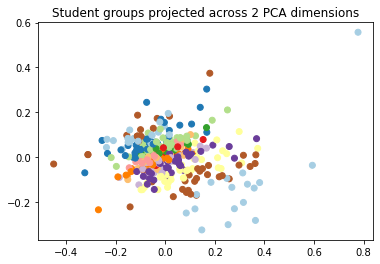

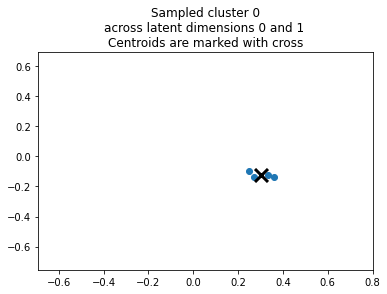

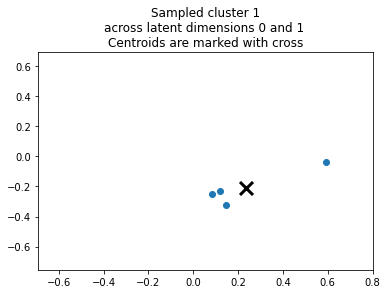

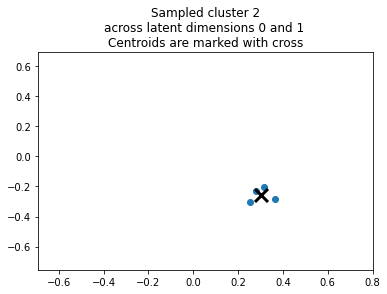

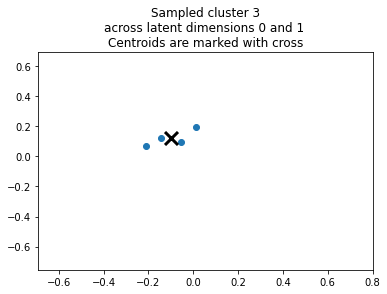

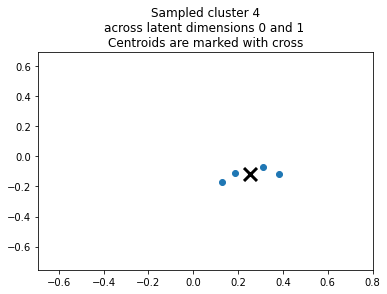

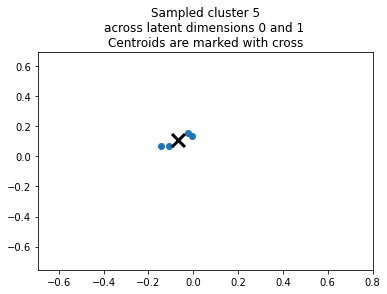

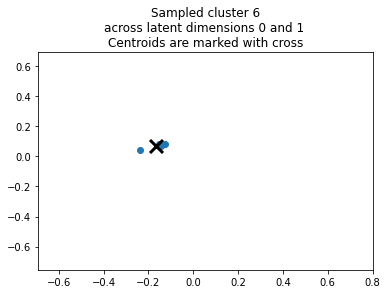

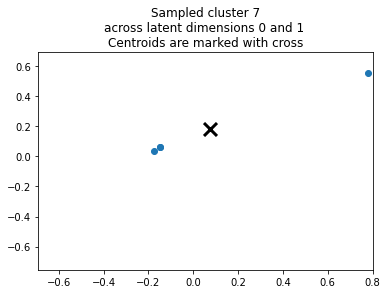

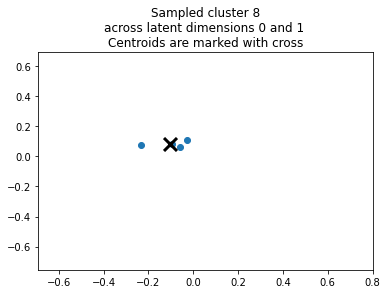

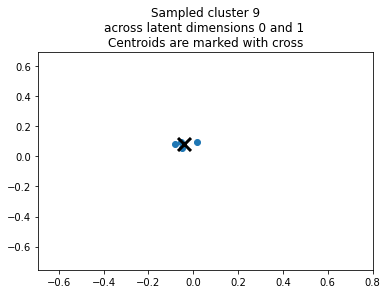

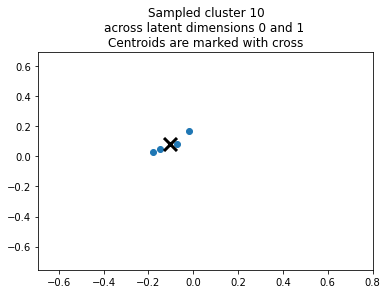

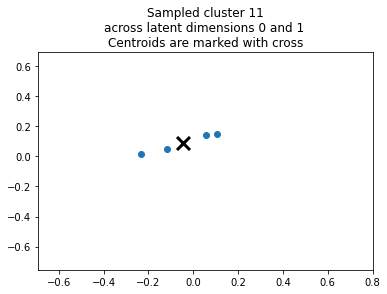

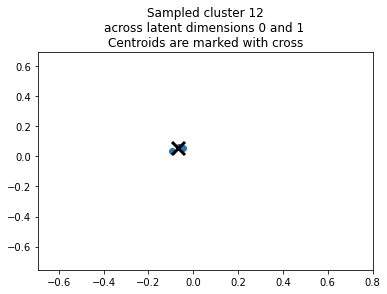

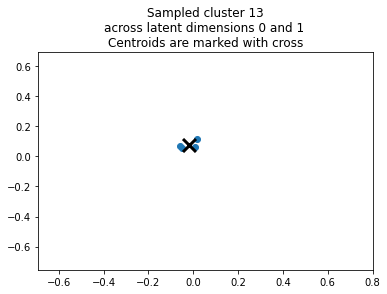

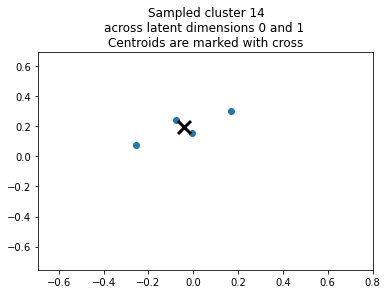

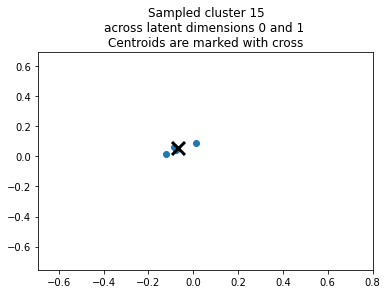

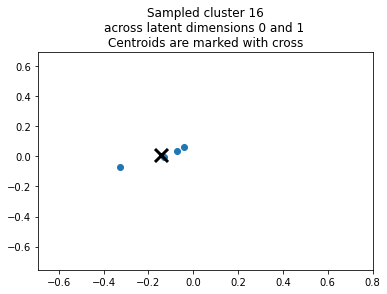

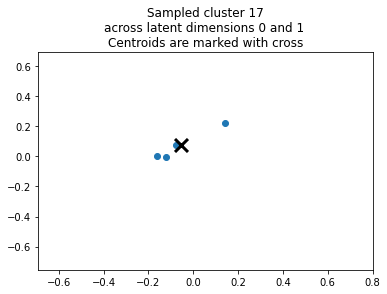

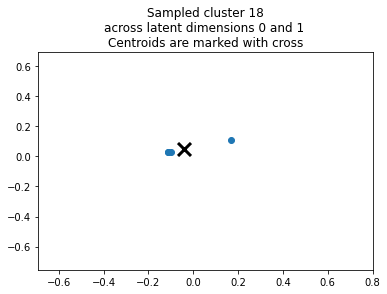

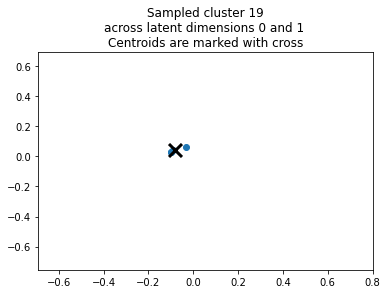

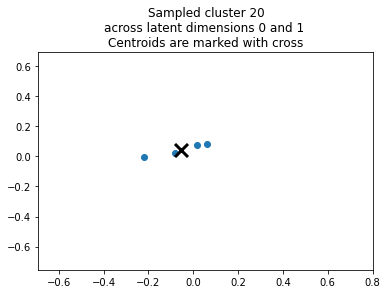

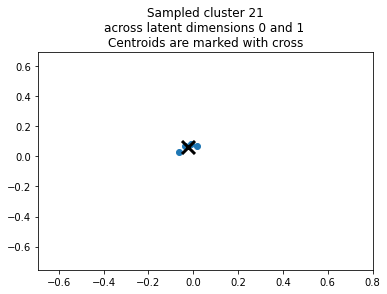

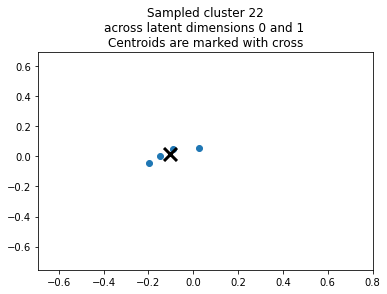

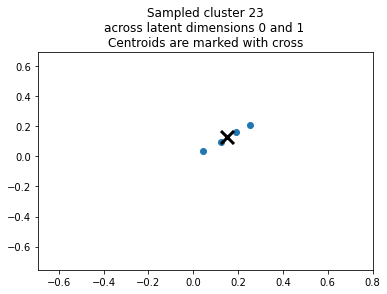

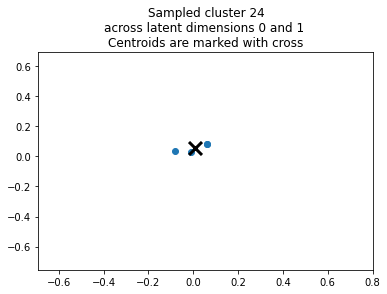

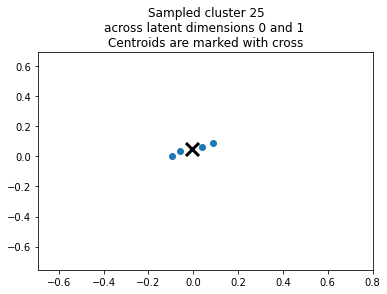

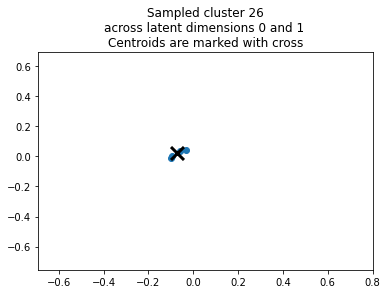

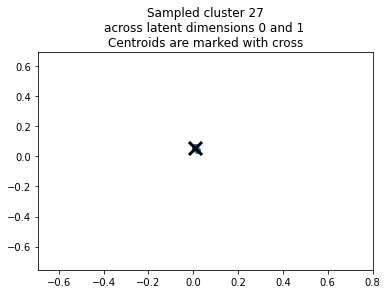

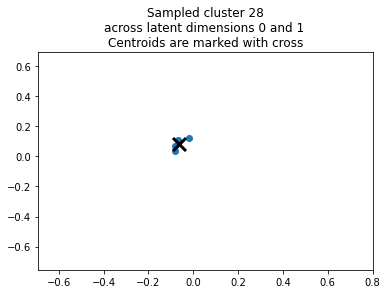

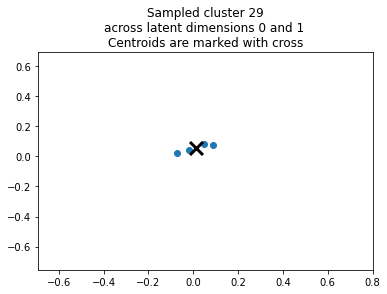

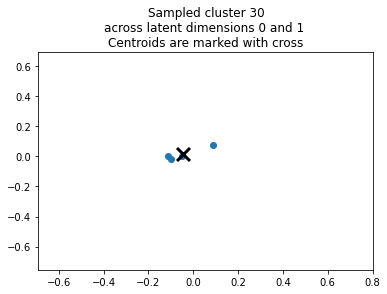

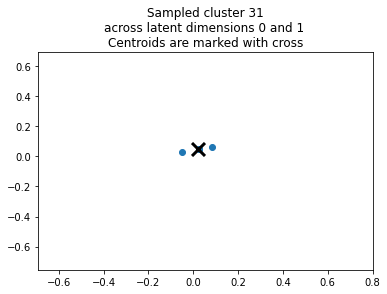

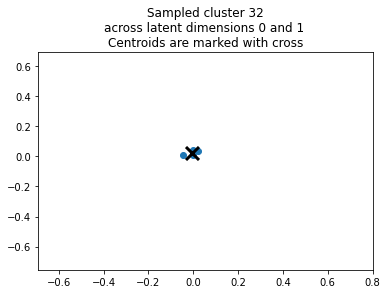

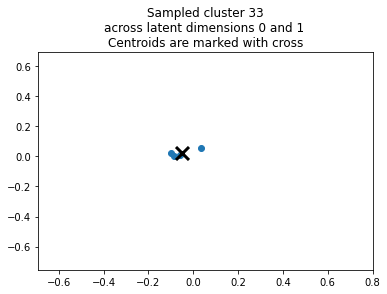

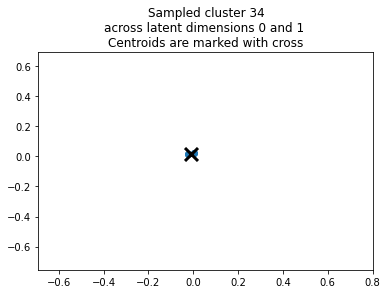

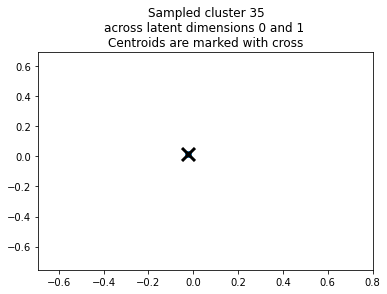

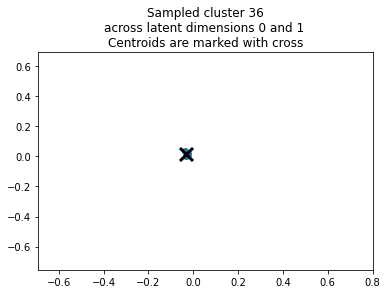

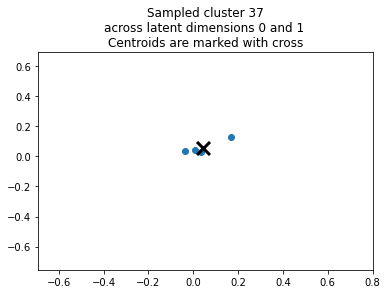

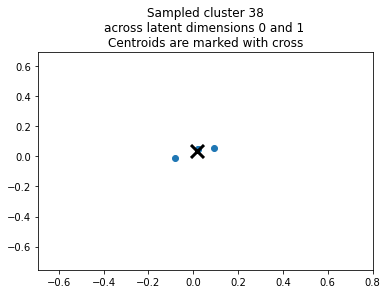

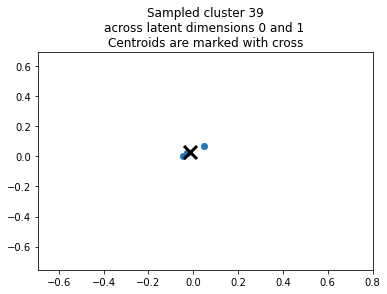

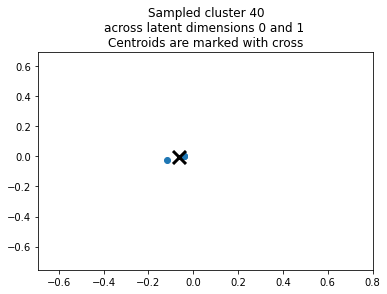

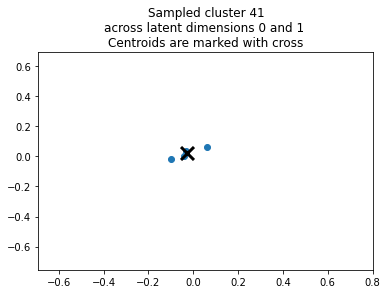

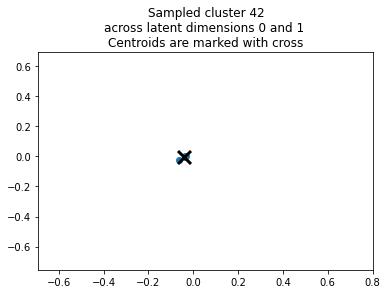

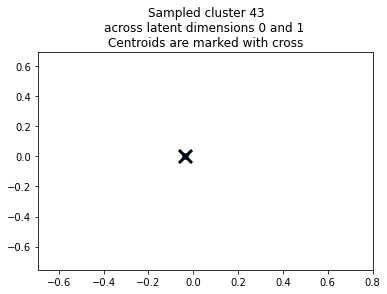

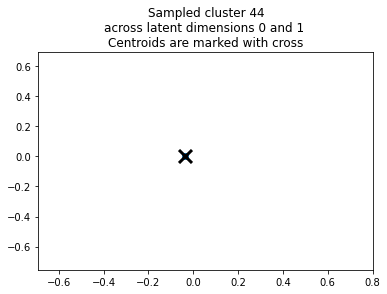

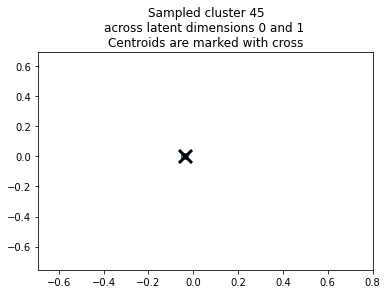

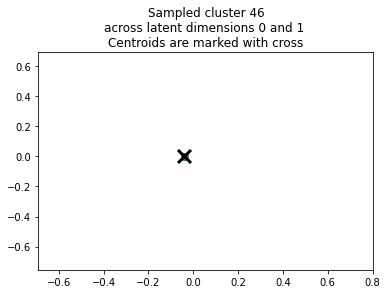

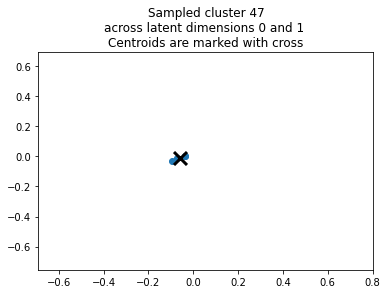

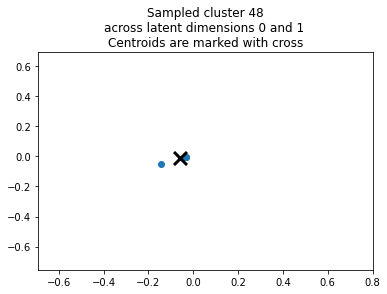

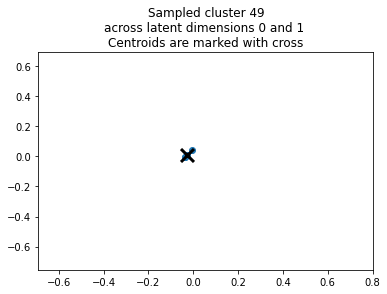

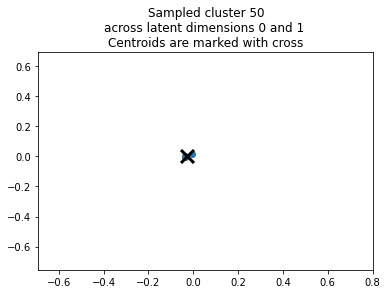

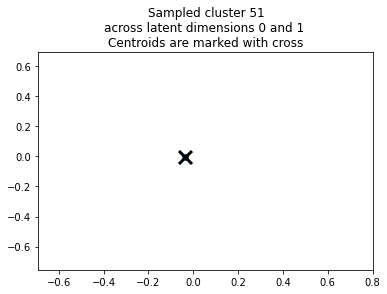

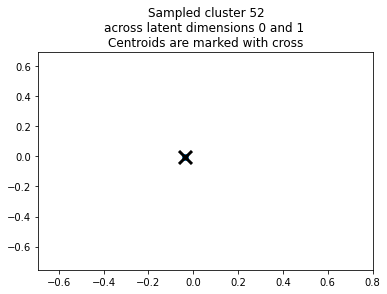

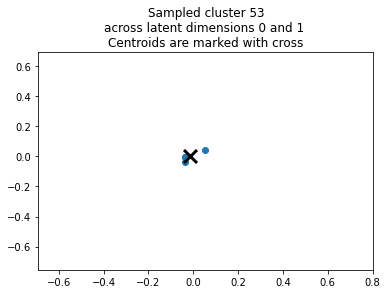

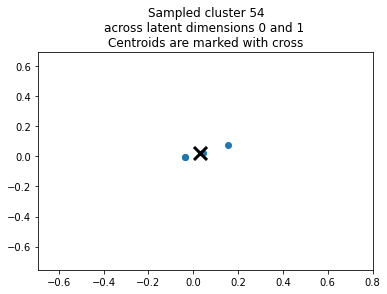

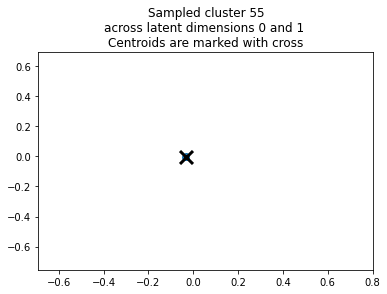

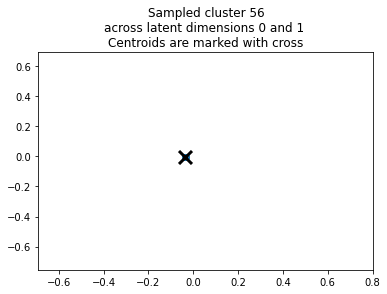

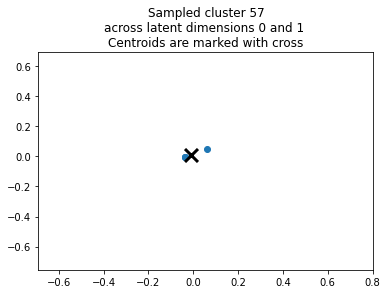

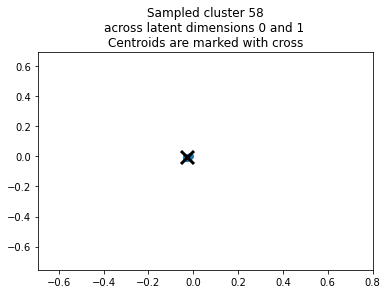

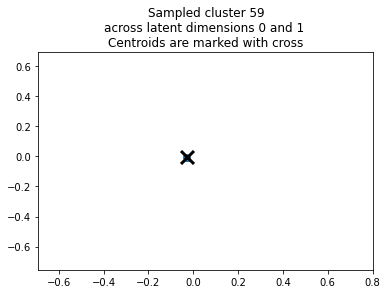

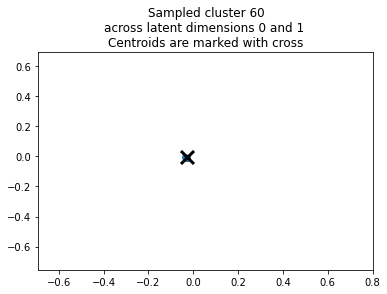

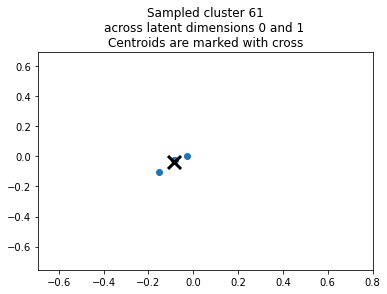

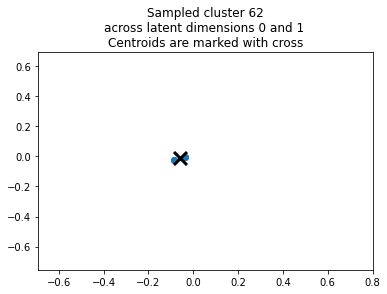

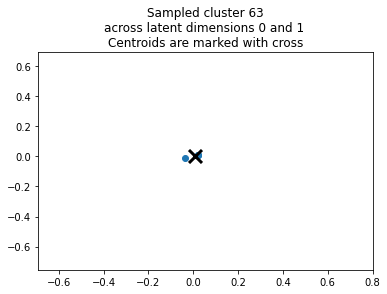

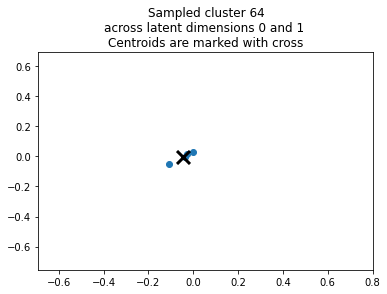

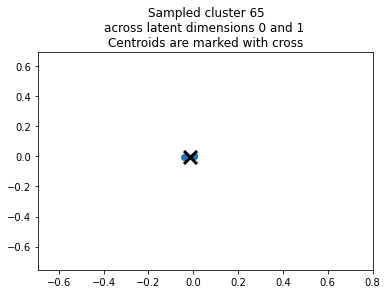

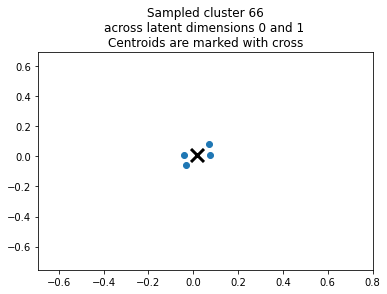

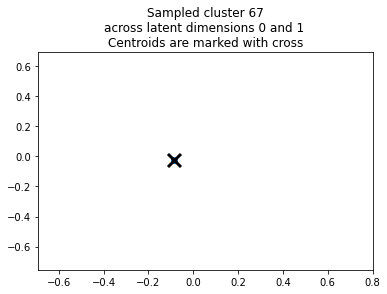

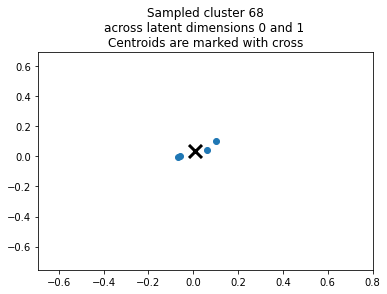

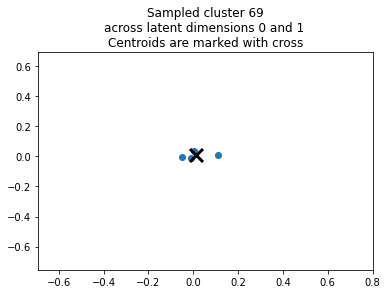

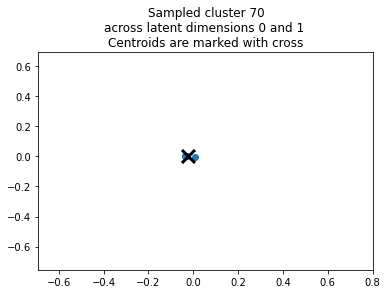

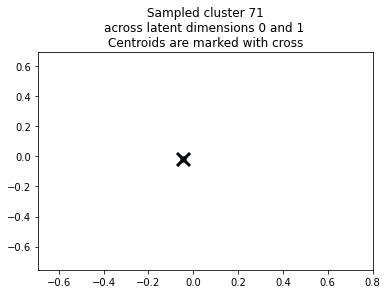

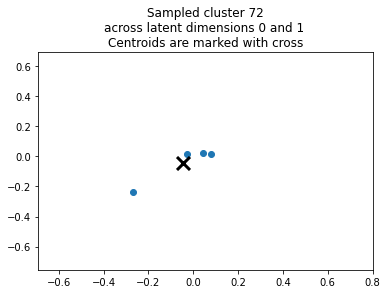

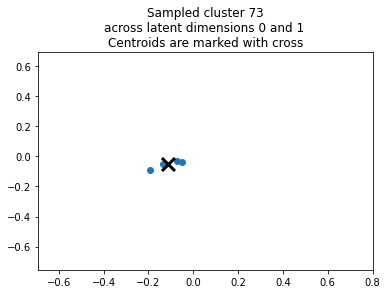

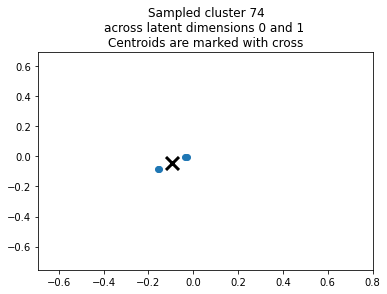

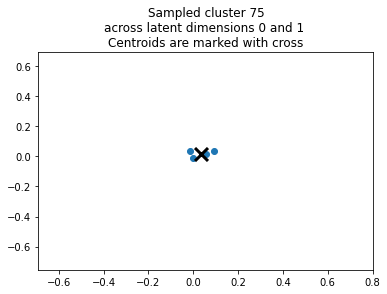

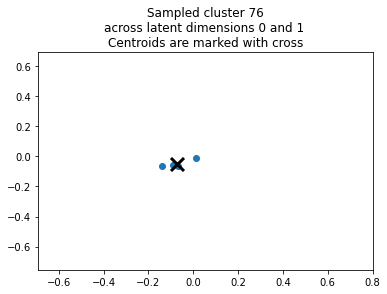

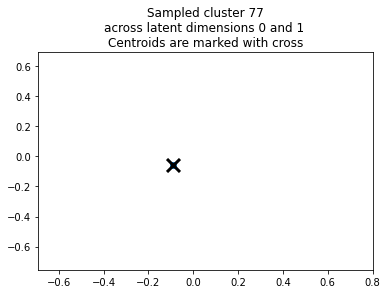

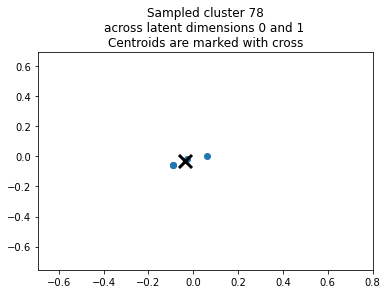

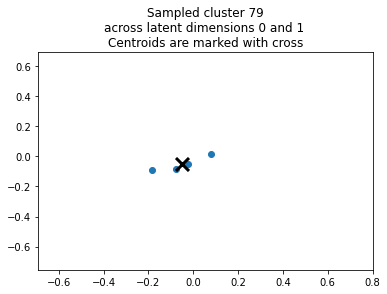

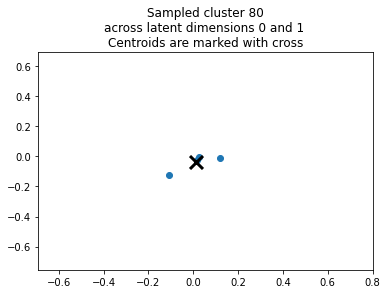

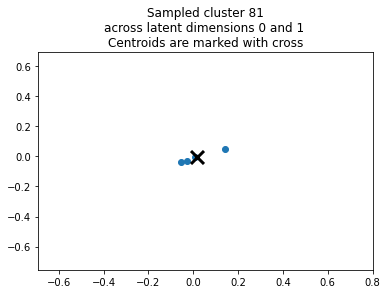

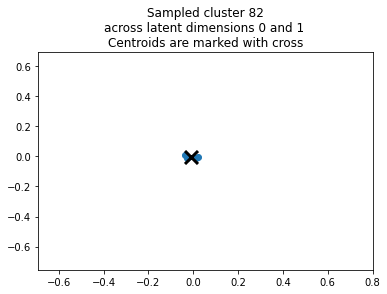

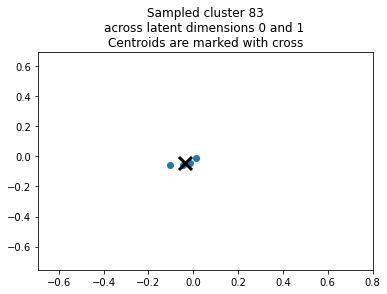

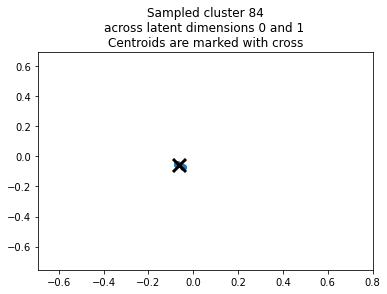

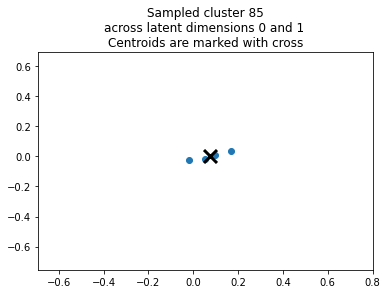

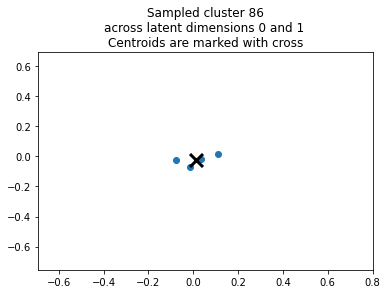

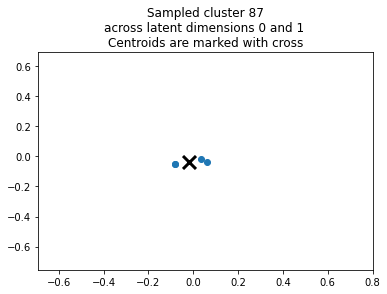

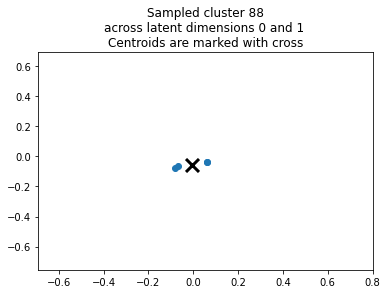

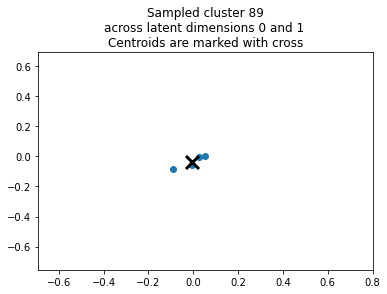

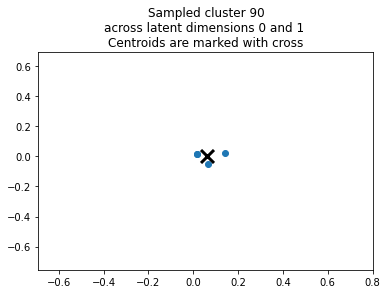

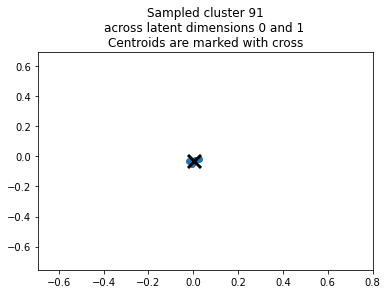

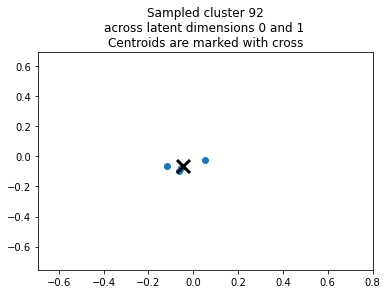

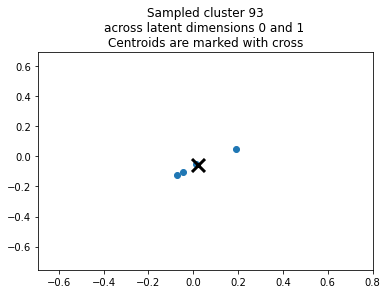

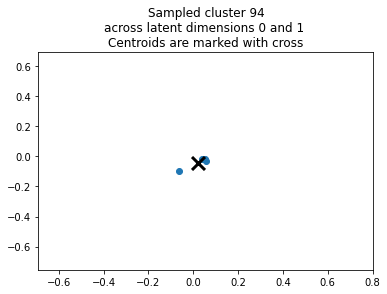

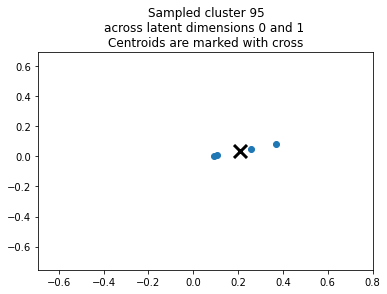

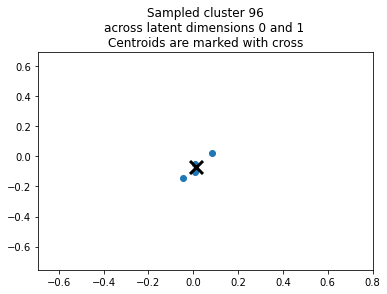

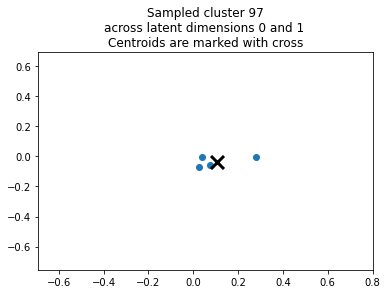

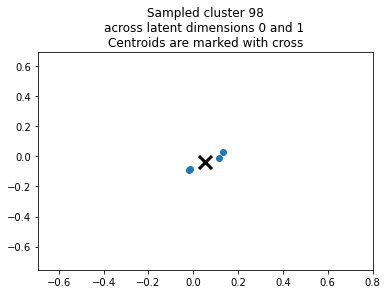

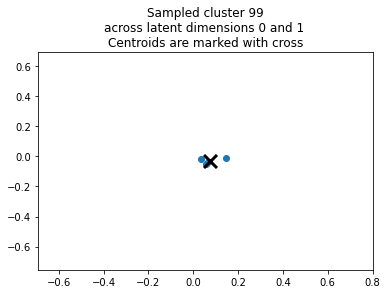

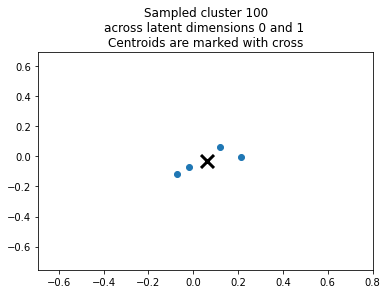

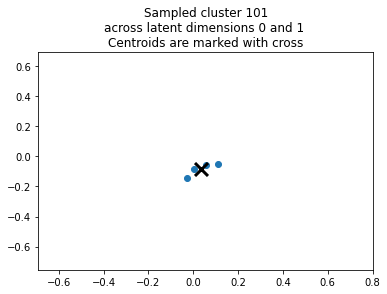

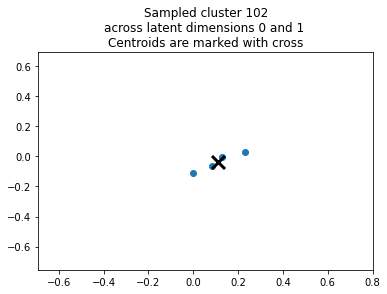

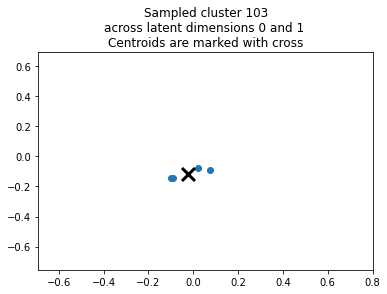

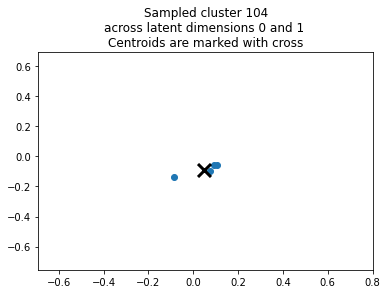

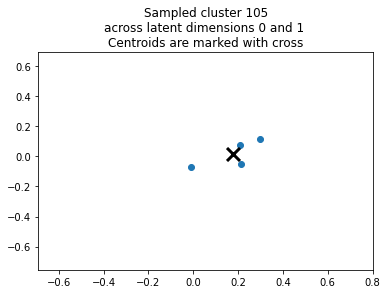

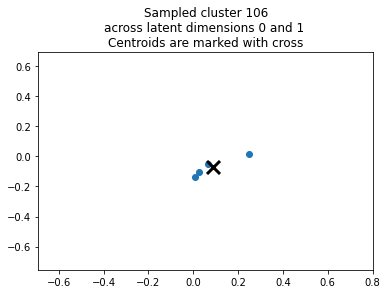

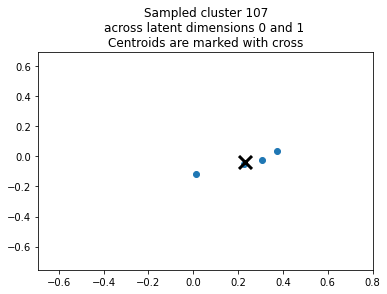

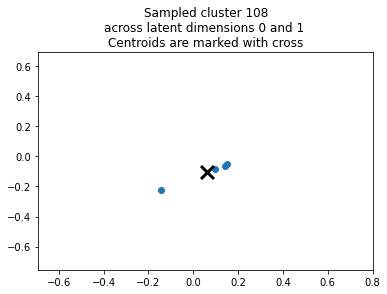

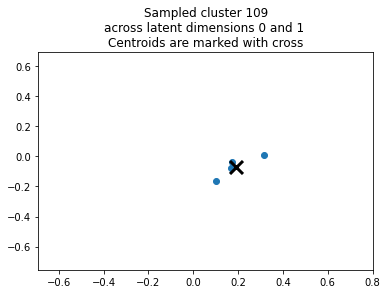

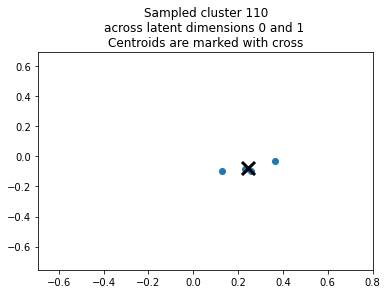

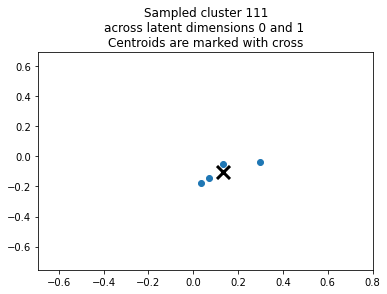

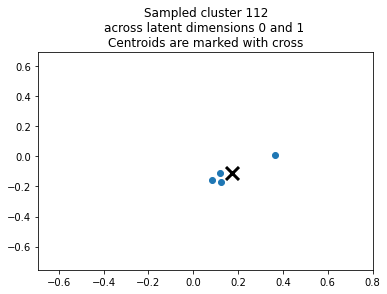

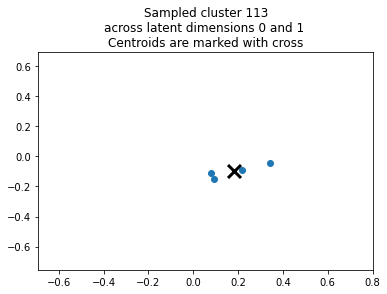

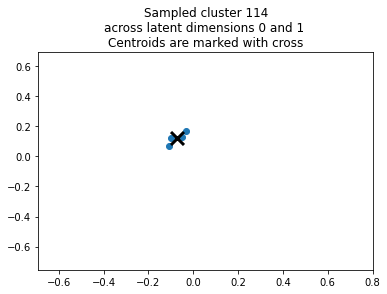

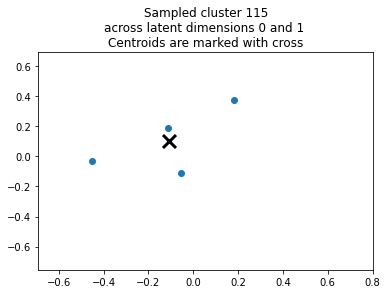

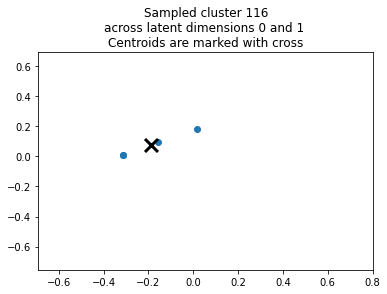

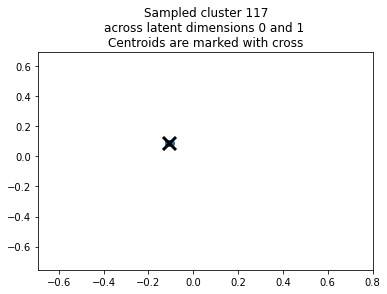

In [65]:
visualize_dec_results(dec_actor, X)

In [ ]:
# z_eval = dec_actor.encode(ptu.from_numpy(X_eval))

In [67]:
print(np.unique(dec_actor.mu.detach().numpy(), axis=0))

[[-0.5656894   0.0803567   0.12652397  0.00581281  0.09536655  0.11557374
  -0.14941904  0.24181941]
 [-0.5655368   0.07720257  0.12853217  0.01005212  0.08973612  0.11610463
  -0.1455042   0.23855191]
 [-0.5629678   0.07533103  0.12848842  0.00815238  0.09518532  0.11695414
  -0.14473058  0.2413837 ]
 [-0.5629481   0.07427367  0.12990704  0.0094446   0.0985281   0.11912324
  -0.14705412  0.24415146]
 [-0.5618971   0.07798281  0.12686935  0.00971986  0.09552926  0.11343366
  -0.1454502   0.2412248 ]
 [-0.56177425  0.07848017  0.12570213  0.00511726  0.09498113  0.11594027
  -0.14519255  0.24358246]]


In [51]:
p_final,q_final,z_final = dec_actor.forward(ptu.from_numpy(X))
group_counts, counts =np.unique(np.argmax(p_final.detach().numpy(), axis=1), return_counts=True)
for i in range(group_counts.shape[0]):
    print(group_counts[i], counts[i])

0 122
1 44
2 40
3 21
4 127
115 118


In [46]:
a = np.array([[1, 2],
              [2, 3]])